In [1]:
# Setup environment
# Read-in 'lifeexpectancy' database with SQL query 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sqlalchemy import create_engine
import warnings
import missingno as msno

from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# Sngle query
engine.dispose()

THE FOLLOWING VARIABLE LIST WAS EXTRACTED FROM KAGGLE TO EASE INTERPRETATION OF VARIABLE MEANING THROUGHOUT NOTEBOOK</br>
****

**Country:** Country</br>

**Year:** Year</br>

**Status:** Developed or Developing status</br>

**Life expectancy:** Life Expectancy in age</br>

**Adult Mortality:** Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)</br> 

**infant deaths:** Number of Infant Deaths per 1000 population</br>

**Alcohol:** Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)</br>

**percentage expenditure:** Expenditure on health as a percentage of Gross Domestic Product per capita(%)</br>

**Hepatitis B:** Hepatitis B (HepB) immunization coverage among 1-year-olds (%)</br>

**Measles:** Measles - number of reported cases per 1000 population</br>

**BMI:** Average Body Mass Index of entire population</br>

**under-five deaths:** Number of under-five deaths per 1000 population</br>

**Polio:** Polio (Pol3) immunization coverage among 1-year-olds (%)</br>

**Total expenditure:** General government expenditure on health as a percentage of total government expenditure (%)</br>

**Diphtheria:** Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)</br>

**HIV/AIDS:** Deaths per 1,000 live births HIV/AIDS (0-4 years)</br>

**GDP:** Gross Domestic Product per capita (in USD)</br>

**Population:** Population of the country</br>

**thinness 1-19 years:** Prevalence of thinness among children and adolescents for Age 10 to 19 (%)</br>

**thinness 5-9 years:** Prevalence of thinness among children for Age 5 to 9(%)</br>

**Income composition of resources:** Human Development Index in terms of income composition of resources (index ranging from 0 to 1)</br>

**Schooling:** Number of years of Schooling (years)</br>

# Exploratory Data Analysis (EDA)

This will require several steps:

1.1 Data Cleaning</br>

1.2 Outlier Detection/Treatment</br>

1.3 Data Exploration (univariate and multivariate analysis)</br>

1.4 Feature Engineering</br>


***
## Data Cleaning
***

In [2]:
# First, convert column headings to lower case, stripped of white space, space and other characters replaced with underscores
# Second, the thinness_1_19_years should be renamed --> this variable concerns the age range 10-19 years old
df.columns = df.columns.str.strip().str.lower().str.replace('  ', '_').str.replace(' ','_').str.replace('-', '_').str.replace('/', '_')
df.rename(columns={"thinness_1_19_years": "thinness_10_19_years"}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under_five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv_aids                           2938 non-null

In [3]:
# We should go ahead and check the null objects for all numeric data types. This will be done using a try/except type function
# First create iterable list from index of eda_df, check for numeric, then loop through observations to check non-null data entry
var_list = df.columns
numeric_var_list = []
for var in var_list:
    count = 0
    if df[var].dtypes != 'object':
        numeric_var_list.append(var)
        print('Numeric Column: {}'.format(var))
        for datapoint in df[var]:
            try:
                float(datapoint)
            except:
                print(datapoint)
                count +=1
        print('There are {} potential problem values for column: {}'.format(count, var))
        print(100 * '-')

Numeric Column: year
There are 0 potential problem values for column: year
----------------------------------------------------------------------------------------------------
Numeric Column: life_expectancy
There are 0 potential problem values for column: life_expectancy
----------------------------------------------------------------------------------------------------
Numeric Column: adult_mortality
There are 0 potential problem values for column: adult_mortality
----------------------------------------------------------------------------------------------------
Numeric Column: infant_deaths
There are 0 potential problem values for column: infant_deaths
----------------------------------------------------------------------------------------------------
Numeric Column: alcohol
There are 0 potential problem values for column: alcohol
----------------------------------------------------------------------------------------------------
Numeric Column: percentage_expenditure
There are 0 p

In [4]:
## Seems like the missing values are true missing numbers (nan)
## But we should also check for number of unique values in categorical variables, 'country' and 'status'
## The Kaggle data description states that there are 193 total countries and 2 levels of status ('developed', 'developing')
print('Status: Number of unique values = {}\nStatus: Unique entries = {}'.format(df['status'].nunique(), df['status'].unique()))
print(100 * '-')
print('Country: Number of unique values = {}\nCountry: Unique entries = {}'.format(df['country'].nunique(), df['country'].unique()))

Status: Number of unique values = 2
Status: Unique entries = ['Developing' 'Developed']
----------------------------------------------------------------------------------------------------
Country: Number of unique values = 193
Country: Unique entries = ['Afghanistan' 'Albania' 'Algeria' "Côte d'Ivoire" 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Slovakia'
 'Equatorial 

In [5]:
## Full complement of non-null values = 2938 x 22 variables
## First let's define a function that takes 'df' as input 
## Returns a dataframe where each feature in dataset is now a row and the summary statistics are columns
def df_to_eda(data):
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_%'] = round(100*df.isnull().mean(),1)
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    return pd.DataFrame(eda_df)
    
df_to_eda(df)

,null_sum,null_%,dtypes,count,mean,median,min,max
adult_mortality,10,0.3,float64,2928,1.647964e+02,1.440000e+02,1,723
alcohol,194,6.6,float64,2744,4.602861e+00,3.755000e+00,0.01,17.87
bmi,34,1.2,float64,2904,3.832125e+01,4.350000e+01,1,87.3
country,0,0.0,object,2938,NaN,NaN,Afghanistan,Zimbabwe
diphtheria,19,0.6,float64,2919,8.232408e+01,9.300000e+01,2,99
gdp,448,15.2,float64,2490,7.483158e+03,1.766948e+03,1.68135,119173
hepatitis_b,553,18.8,float64,2385,8.094046e+01,9.200000e+01,1,99
hiv_aids,0,0.0,float64,2938,1.742103e+00,1.000000e-01,0.1,50.6
income_composition_of_resources,167,5.7,float64,2771,6.275511e-01,6.770000e-01,0,0.948
infant_deaths,0,0.0,int64,2938,3.030395e+01,3.000000e+00,0,1800


***
### Summary of Data and Missingness 
***

* Using df.info(): we have a total of 2938 observations and 22 variables (columns)</br>
* The missing continuous data appear to be true missing values (NaNs)</br>
* The missing categorical data consists of 'status' = developed/developing, and 'country' = 193 unique countries</br>

***
Note on the Population variable
***
The population data appears to contain multiple erroneous entries. An obvious example concerns the population(s) provided for China, which appear to be incorrect by several orders of magnitude. This isn't a straightforward fix as the magnitude differes on a year-by-year basis. The population at 2015 is given as 137122 when the actual population was about 1.371 billion. The population at 2002 is given as 1284 when the actual population was about 1.28 billion.</br>

The United States Census Bureau (UCSB) stores international population data for most countries from 1950 to the present day, with predicted data extending to 2050. Hence, for the current project, the https://www.census.gov/data-tools/demo/idb/informationGateway.php website was utilized to recreate accurate population data for the countries of concern. The next few cells concern the generation of a correct population column using a CSV file that can be obtained from my GitHub. Note that the USCB data is downloaded with countries idenitfied by their Federal Information Processing Standard (FIPS) idenifier. This was used to cross-reference country and population figures from the 'lifeexpectancy' database and UCSB data.</br></br>


***
Note on 'nonsense' values
***
There appear to be some 'nonsense' variables. This is especially apparent considering some of the min and max values reported using the df_to_eda function. For example:</br>

**Adult mortality rates:** range from 0(!?) to 723. Given that this is the probability of dying between 15 and 60 years per 1000 population, some numbers appear off</br>

**Infant deaths:** Similarly, infant deaths (# per 1000 population) 0 (min) to 1800 (max) appears to have erroneous entries</br>

**Under 5 deaths:** As above for infant deaths</br>

**Population:** way off for some countries, e.g. China (please see below)</br>

**BMI:** also has nonsense data, ranging from 1 to 87. Given that healthy BMI range is between 18.5 - 24.9, these are obviously erroneous entries</br>



***
### Importing Accurate Population Data
***

In [6]:
## Read file UCSB CSV from Github
df_idb = pd.read_csv('https://raw.githubusercontent.com/aprescot1977/Thinkful/master/Populations_IDB_03262020.csv')
## Keep relevant years (2000-2015)
df_idb = df_idb[(df_idb['year']>=2000)&(df_idb['year']<=2015)]

In [7]:
## Note this cell requires time-consuming user inputs for all 193 countries
## 'fips_code_flag' is set to False. The following cell uses the list of strings that was outputted, preventing the need to do this again
fips_code_flag = False
if fips_code_flag:
    countries = df['Country'].unique()
    tmp = dict()
    for ii,jj in enumerate(countries):
        tmp[jj] = input('Country is: {}, please enter FIPS code'.format(jj))
        print('*'*100)

In [8]:
## FIPS identifiers for 193 countries: as taken from list of strings generated in above cell
fips = ['AF', 'AL', 'AG', 'IV', 'AO', 'AC', 'AR', 'AM', 'AS', 'AU', 'AJ',
       'BF', 'BA', 'BG', 'BB', 'BO', 'BE', 'BH', 'BN', 'BT', 'BL', 'BK',
       'BC', 'BR', 'BX', 'BU', 'UV', 'BY', 'CV', 'CB', 'CM', 'CA', 'CT',
       'CD', 'CI', 'CH', 'CO', 'CN', 'CF', 'CW', 'CS', 'HR', 'CU', 'CY',
       'EZ', 'KN', 'CG', 'DK', 'DJ', 'DO', 'DR', 'EC', 'EG', 'ES', 'LO',
       'EK', 'ER', 'EN', 'ET', 'FJ', 'FI', 'FR', 'GB', 'GA', 'GG', 'GM',
       'GH', 'GR', 'GI', 'GT', 'GV', 'PU', 'GY', 'HA', 'HO', 'HU', 'IC',
       'IN', 'ID', 'IR', 'IZ', 'EI', 'IS', 'IT', 'JM', 'JA', 'JO', 'KZ',
       'KE', 'KR', 'KU', 'KG', 'LA', 'LG', 'LE', 'LT', 'LI', 'LY', 'LH',
       'LU', 'MA', 'MI', 'MY', 'MV', 'ML', 'MT', 'RM', 'MR', 'MP', 'MX',
       'FM', 'MN', 'MG', 'MJ', 'MO', 'MZ', 'BM', 'WA', 'NR', 'NP', 'NL',
       'NZ', 'NU', 'NG', 'NI', 'NE', 'NO', 'MU', 'PK', 'PS', 'PM', 'PP',
       'PA', 'PE', 'RP', 'PL', 'PO', 'QA', 'KS', 'MD', 'RO', 'RS', 'RW',
       'SC', 'ST', 'VC', 'WS', 'SM', 'TP', 'SA', 'SG', 'RI', 'SE', 'SL',
       'SN', 'SI', 'BP', 'SO', 'SF', 'OD', 'SP', 'CE', 'SU', 'NS', 'WZ',
       'SW', 'SZ', 'SY', 'TI', 'TH', 'MK', 'TT', 'TO', 'TN', 'TD', 'TS',
       'TU', 'TX', 'TV', 'UG', 'UA', 'AE', 'UK', 'TZ', 'US', 'UY', 'UZ',
       'NH', 'VE', 'VN', 'YM', 'ZA', 'ZI']

In [9]:
## Create dictionary for country (keys) and fips ID (index)
## Create new column in master dataframe with fips IDs
countries = df['country'].unique()
country_fips = dict(zip(countries, fips))
for country in countries:
    df.loc[df['country']==country, 'fips_code'] = country_fips[country]

In [10]:
## Grab correct population data from 'df_idb'
for ii in df['fips_code'].unique():
    #print('country = {}'.format(ii))
    for jj in df[df['fips_code']==ii]['year'].unique():
        df.loc[(df['fips_code']==ii)&(df['year']==jj), 'population_uscb'] = df_idb.loc[(df_idb['fips']==ii)&(df_idb['year']==jj), 'pop'].to_list()

In [11]:
# Check China for example
df[df['country']=='China']

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,diphtheria,hiv_aids,gdp,population,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling,fips_code,population_uscb
560,China,2015,Developing,76.1,85.0,157,NaN,0.000000,99.0,42361,...,99.0,0.1,869.211938,137122.0,3.6,2.9,0.734,13.5,CH,1.367485e+09
561,China,2014,Developing,75.8,86.0,171,5.78,109.874390,99.0,52628,...,99.0,0.1,7683.523800,136427.0,3.7,3.0,0.723,13.1,CH,1.361344e+09
562,China,2013,Developing,75.6,88.0,185,5.79,9.955532,99.0,26883,...,99.0,0.1,777.775940,135738.0,3.8,3.2,0.713,12.7,CH,1.355286e+09
563,China,2012,Developing,75.4,89.0,201,5.74,94.434457,99.0,6183,...,99.0,0.1,6337.882993,135695.0,3.9,3.3,0.703,12.4,CH,1.349161e+09
564,China,2011,Developing,75.2,91.0,215,5.63,91.267498,99.0,9943,...,99.0,0.1,5633.796160,134413.0,4.1,3.5,0.700,12.8,CH,1.342946e+09
565,China,2010,Developing,75.0,92.0,231,5.75,5.660755,99.0,38159,...,99.0,0.1,456.512487,133775.0,4.2,3.6,0.691,12.5,CH,1.336681e+09
566,China,2009,Developing,74.9,93.0,248,4.88,50.283489,99.0,52461,...,99.0,0.1,3838.434292,133126.0,4.4,3.8,0.682,12.2,CH,1.330233e+09
567,China,2008,Developing,74.5,97.0,266,4.27,39.225097,95.0,131441,...,97.0,0.1,3471.247547,1324655.0,4.5,4.0,0.672,11.9,CH,1.323480e+09
568,China,2007,Developing,74.4,96.0,285,3.88,312.662482,92.0,109023,...,93.0,0.1,2695.366223,1317885.0,4.7,4.1,0.659,11.4,CH,1.316490e+09
569,China,2006,Developing,74.2,98.0,307,3.28,29.743430,91.0,99602,...,93.0,0.1,299.229676,13112.0,4.8,4.3,0.646,11.0,CH,1.309395e+09


In [12]:
# Population (population_uscb) is also fully represented, no missing values. Let's drop original population column too as well as fips_code
df = df.drop(['population', 'fips_code'], axis=1)
df_to_eda(df)


,null_sum,null_%,dtypes,count,mean,median,min,max
adult_mortality,10,0.3,float64,2928,1.647964e+02,1.440000e+02,1,723
alcohol,194,6.6,float64,2744,4.602861e+00,3.755000e+00,0.01,17.87
bmi,34,1.2,float64,2904,3.832125e+01,4.350000e+01,1,87.3
country,0,0.0,object,2938,NaN,NaN,Afghanistan,Zimbabwe
diphtheria,19,0.6,float64,2919,8.232408e+01,9.300000e+01,2,99
gdp,448,15.2,float64,2490,7.483158e+03,1.766948e+03,1.68135,119173
hepatitis_b,553,18.8,float64,2385,8.094046e+01,9.200000e+01,1,99
hiv_aids,0,0.0,float64,2938,1.742103e+00,1.000000e-01,0.1,50.6
income_composition_of_resources,167,5.7,float64,2771,6.275511e-01,6.770000e-01,0,0.948
infant_deaths,0,0.0,int64,2938,3.030395e+01,3.000000e+00,0,1800


***
### Nonsense Values
***

We should try and deal with nonsense values first and revisit where we are at with NaNs before moving on to their treatment. First, let's replace zeros with NaNs for both 'infant_deaths' and 'under_five_deaths"

In [13]:
df['infant_deaths'] = df['infant_deaths'].replace(0, np.nan)
df['under_five_deaths'] = df['under_five_deaths'].replace(0, np.nan)

Now considering 'bmi'. If underweight is <18.5, 18.5 to 25 is normal, 25 to 30 deemed overweight, obese >30, extremely obese >35, then we need to define a range and set values outside the range to NaN. Let's replace bmi<10 and bmi>40 to NaNs. This will be a single-shot function (as will be for adult_mortality) so we should push for using lambda functions.

In [14]:
df['bmi'] = df.apply(lambda ii: np.nan if (ii['bmi']<10 or ii['bmi']>40) else ii['bmi'], axis=1)

Now considering 'adult_mortality'.  

In [15]:
adult_5thpc = np.percentile(df['adult_mortality'].dropna(), 5) # use dropna() as there are 10 NaN values to begin with. Avoid errors
print('We will drop adult_mortality values lower than {} (5th percentile)'.format(adult_5thpc))
df['adult_mortality'] = df.apply(lambda ii: np.nan if ii['adult_mortality']<adult_5thpc else ii['adult_mortality'], axis=1)

We will drop adult_mortality values lower than 13.0 (5th percentile)


***
### Visualization: where do we stand?
***

The missingno library provides excellent visual representation of df.info() on a row-by-row (matrix) and column-by-column (bar) basis. So let's see where we are at with missing values.

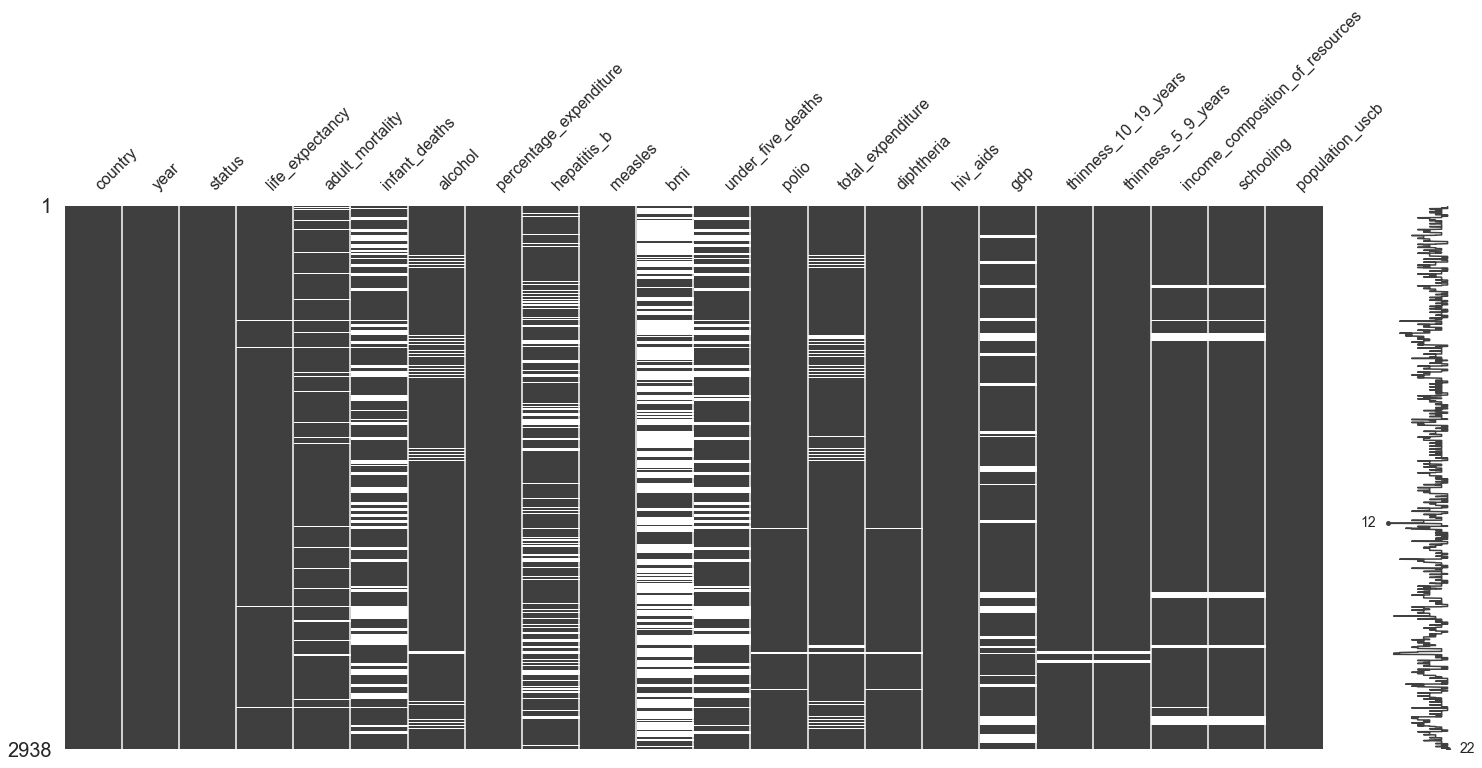

In [16]:
# Row-by-row
msno.matrix(df)

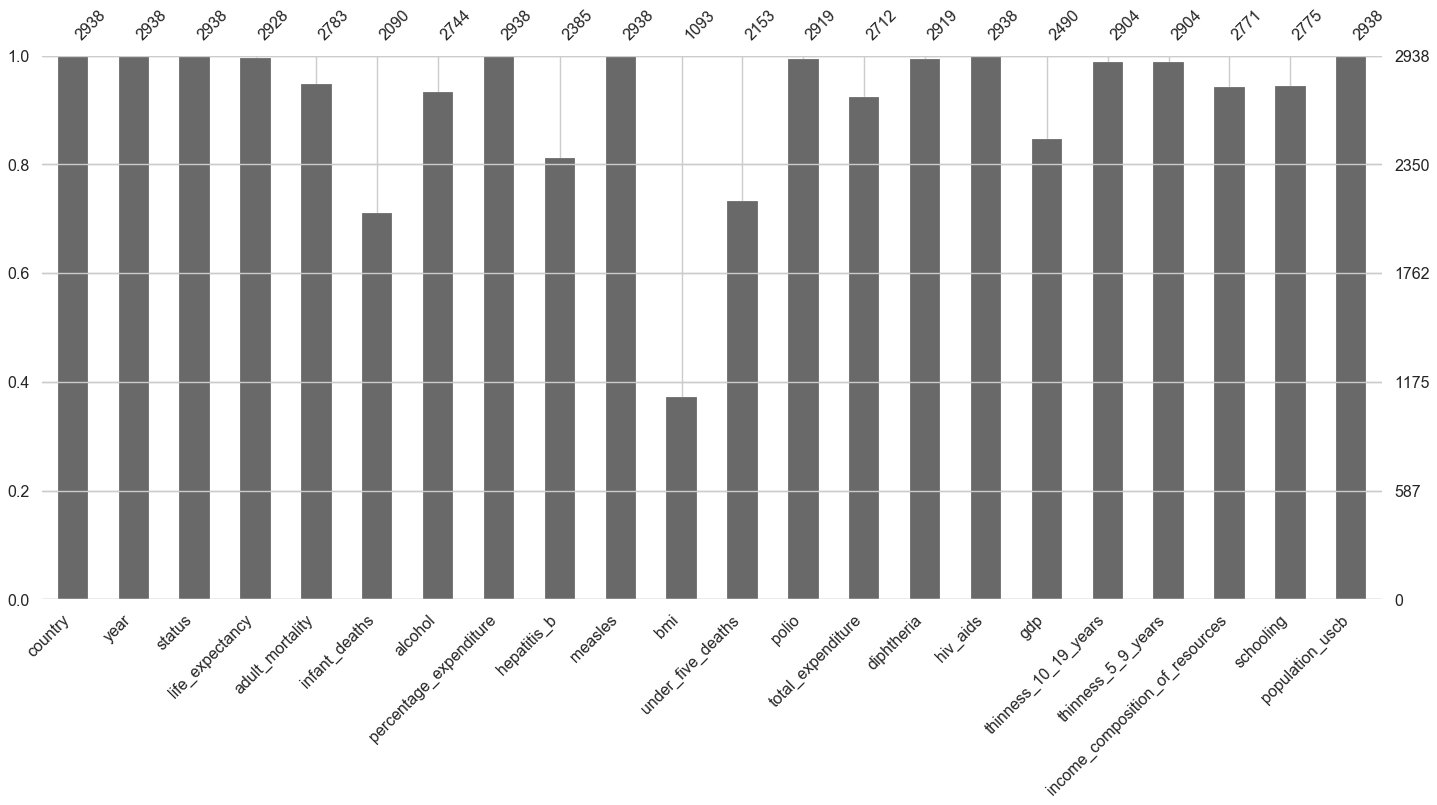

In [17]:
# Columns
msno.bar(df)

The 'bmi' variable is now seriously underpopulated (<40%). Any attempts for imputation would likely introduce poorly represented data for most countries. This variable should thus be dropped.

In [18]:
df = df.drop(['bmi'], axis=1)

The missingno library can be used to provide heatmaps that measure data nullity correlation: ie how strongly the presence or absence of one variable affects the presence of another</br>

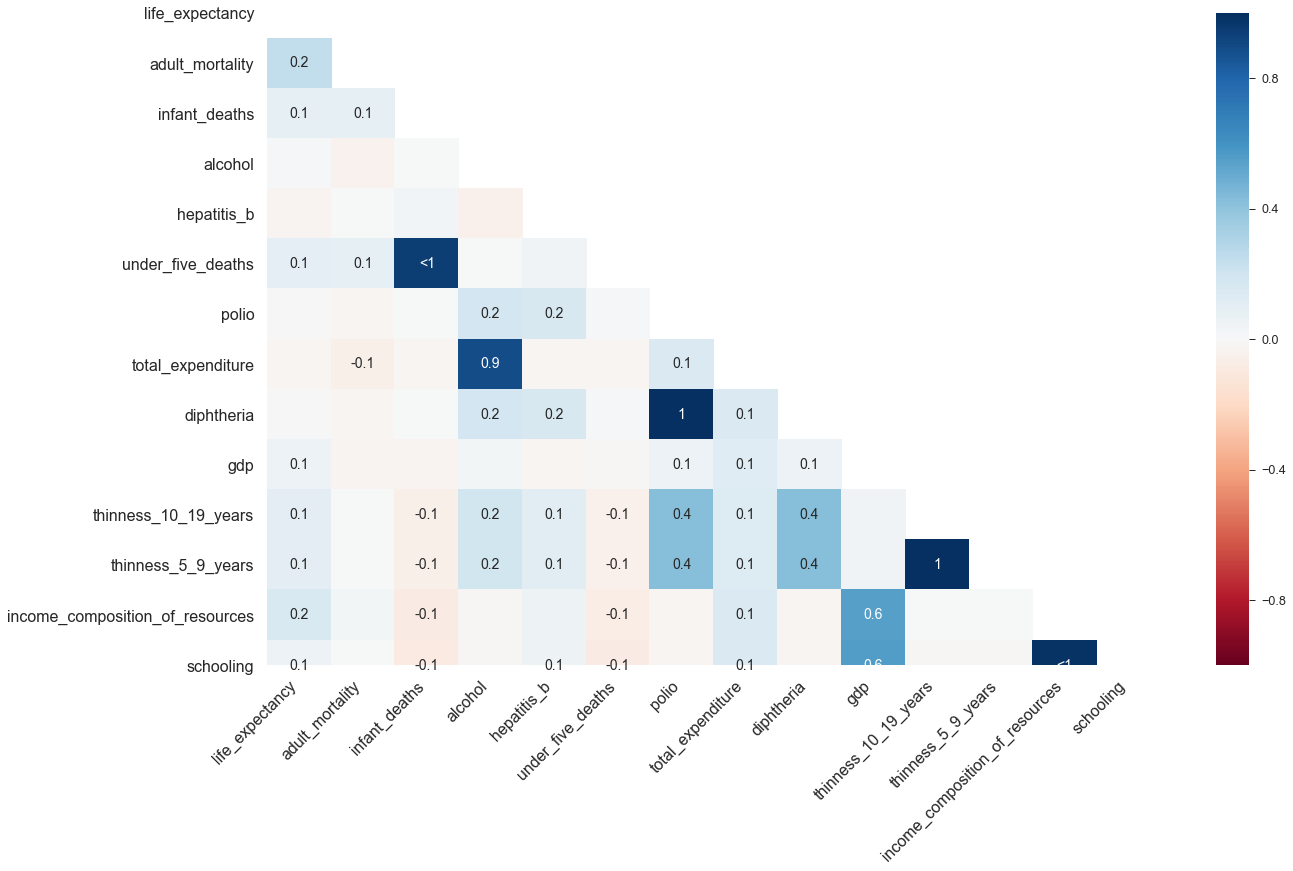

In [19]:
msno.heatmap(df)

* e.g. 1: 'thinness' variables are 100% correlated with each other in terms of missing values</br>
* e.g. 2: 'diptheria' and 'polio' immunization coverage are 100% correlated in terms of missing values</br>
* e.g. 3: 'income_composition_of_resources' and 'schooling' immunization coverage are ~100% correlated in terms of missing values</br>
* e.g. 4: 'alcohol' cosumption and 'total_expenditure' on healthcare as a fraction on total government expenditure are strongly correlated (0.9)
* e.g. 5: 'under_five_deaths'  and 'infant_deaths' are strongly correlated (~100%)
* Dealing with these nullity-correlated variables as pairs may help with treating missing data</br>

In [20]:
df_to_eda(df)

,null_sum,null_%,dtypes,count,mean,median,min,max
adult_mortality,155,5.3,float64,2783,1.729669e+02,1.480000e+02,13,723
alcohol,194,6.6,float64,2744,4.602861e+00,3.755000e+00,0.01,17.87
country,0,0.0,object,2938,NaN,NaN,Afghanistan,Zimbabwe
diphtheria,19,0.6,float64,2919,8.232408e+01,9.300000e+01,2,99
gdp,448,15.2,float64,2490,7.483158e+03,1.766948e+03,1.68135,119173
hepatitis_b,553,18.8,float64,2385,8.094046e+01,9.200000e+01,1,99
hiv_aids,0,0.0,float64,2938,1.742103e+00,1.000000e-01,0.1,50.6
income_composition_of_resources,167,5.7,float64,2771,6.275511e-01,6.770000e-01,0,0.948
infant_deaths,848,28.9,float64,2090,4.259952e+01,9.000000e+00,1,1800
life_expectancy,10,0.3,float64,2928,6.922493e+01,7.210000e+01,36.3,89


Keeping in mind that we only begin with <3000 observations. Ideally we prefer to **impute** missing data rather than **disregarding** rows with missing values. We will try to work on missing data on a top down basis (most missingness to less so) and, where applicable, on combinations of variables whose missingness are strongly correlated. Hence, we will treat missing data in the following order:</br>

* infant_deaths and under_five_deaths
* hepatitis b
* gdp
* alcohol and total_expenditure
* adult mortality
* schooling and income_composition_of_resources
* thinness variables
* polio and diptheria
* life_expectancy

Where possible, as the data is time series (2000-2015 entries for most countries), imputation will be performed on a country-by-country basis using (ideally) interpolation. In some cases, missing values may be filled using whole-column based imputation (mean or median). If this is performed, then that specific variable will not be used to analyze effects of 'country' on target variable etc.</br>
</br>

The function defined once below will be used repeatedly and is useful for understanding missingness for each country and for each of the variables listed above.

In [21]:
# Column missingness function
countries = df['country'].unique()
def null_counter(varin):
    for country in countries:
        tmp = df[(df[varin].isnull() == True)&(df['country']==country)][['country']].count()
        print('{} missing value count: {}\t\t{}'.format(varin, tmp['country'], country))

***
### Infant Deaths and Under Five Deaths
***

In [22]:
# Execute null_counter function
null_counter('infant_deaths')

infant_deaths missing value count: 0		Afghanistan
infant_deaths missing value count: 5		Albania
infant_deaths missing value count: 0		Algeria
infant_deaths missing value count: 0		Côte d'Ivoire
infant_deaths missing value count: 0		Angola
infant_deaths missing value count: 16		Antigua and Barbuda
infant_deaths missing value count: 0		Argentina
infant_deaths missing value count: 0		Armenia
infant_deaths missing value count: 0		Australia
infant_deaths missing value count: 16		Austria
infant_deaths missing value count: 0		Azerbaijan
infant_deaths missing value count: 16		Bahamas
infant_deaths missing value count: 16		Bahrain
infant_deaths missing value count: 0		Bangladesh
infant_deaths missing value count: 16		Barbados
infant_deaths missing value count: 7		Belarus
infant_deaths missing value count: 12		Belgium
infant_deaths missing value count: 16		Belize
infant_deaths missing value count: 0		Benin
infant_deaths missing value count: 5		Bhutan
infant_deaths missing value count: 0		Bolivia

infant_deaths missing value count: 0		Turkey
infant_deaths missing value count: 0		Turkmenistan
infant_deaths missing value count: 1		Tuvalu
infant_deaths missing value count: 0		Uganda
infant_deaths missing value count: 0		Ukraine
infant_deaths missing value count: 0		United Arab Emirates
infant_deaths missing value count: 0		United Kingdom of Great Britain and Northern Ireland
infant_deaths missing value count: 0		United Republic of Tanzania
infant_deaths missing value count: 0		United States of America
infant_deaths missing value count: 7		Uruguay
infant_deaths missing value count: 0		Uzbekistan
infant_deaths missing value count: 16		Vanuatu
infant_deaths missing value count: 0		Venezuela (Bolivarian Republic of)
infant_deaths missing value count: 0		Viet Nam
infant_deaths missing value count: 0		Yemen
infant_deaths missing value count: 0		Zambia
infant_deaths missing value count: 0		Zimbabwe


In [23]:
# Execute null_counter function
null_counter('under_five_deaths')

under_five_deaths missing value count: 0		Afghanistan
under_five_deaths missing value count: 1		Albania
under_five_deaths missing value count: 0		Algeria
under_five_deaths missing value count: 0		Côte d'Ivoire
under_five_deaths missing value count: 0		Angola
under_five_deaths missing value count: 16		Antigua and Barbuda
under_five_deaths missing value count: 0		Argentina
under_five_deaths missing value count: 0		Armenia
under_five_deaths missing value count: 0		Australia
under_five_deaths missing value count: 16		Austria
under_five_deaths missing value count: 0		Azerbaijan
under_five_deaths missing value count: 16		Bahamas
under_five_deaths missing value count: 16		Bahrain
under_five_deaths missing value count: 0		Bangladesh
under_five_deaths missing value count: 16		Barbados
under_five_deaths missing value count: 2		Belarus
under_five_deaths missing value count: 0		Belgium
under_five_deaths missing value count: 16		Belize
under_five_deaths missing value count: 0		Benin
under_five_deat

under_five_deaths missing value count: 16		Suriname
under_five_deaths missing value count: 0		Swaziland
under_five_deaths missing value count: 16		Sweden
under_five_deaths missing value count: 16		Switzerland
under_five_deaths missing value count: 0		Syrian Arab Republic
under_five_deaths missing value count: 0		Tajikistan
under_five_deaths missing value count: 0		Thailand
under_five_deaths missing value count: 16		The former Yugoslav republic of Macedonia
under_five_deaths missing value count: 0		Timor-Leste
under_five_deaths missing value count: 0		Togo
under_five_deaths missing value count: 16		Tonga
under_five_deaths missing value count: 12		Trinidad and Tobago
under_five_deaths missing value count: 0		Tunisia
under_five_deaths missing value count: 0		Turkey
under_five_deaths missing value count: 0		Turkmenistan
under_five_deaths missing value count: 1		Tuvalu
under_five_deaths missing value count: 0		Uganda
under_five_deaths missing value count: 0		Ukraine
under_five_deaths missin

In [24]:
# Some countries have a few missing rows, and some have all missing. Interpolate first for these variables and then use column means for those with full missing.
var_list = ['infant_deaths', 'under_five_deaths']
for country in countries:
    df.loc[df['country'] == country, var_list] = df.loc[df['country'] == country, var_list].interpolate()

df[var_list] = df[var_list].fillna(df[var_list].mean())

***
### Hepatitis B
***

In [25]:
# Execute null_counter function
null_counter('hepatitis_b')

hepatitis_b missing value count: 0		Afghanistan
hepatitis_b missing value count: 0		Albania
hepatitis_b missing value count: 4		Algeria
hepatitis_b missing value count: 1		Côte d'Ivoire
hepatitis_b missing value count: 7		Angola
hepatitis_b missing value count: 1		Antigua and Barbuda
hepatitis_b missing value count: 2		Argentina
hepatitis_b missing value count: 0		Armenia
hepatitis_b missing value count: 1		Australia
hepatitis_b missing value count: 0		Austria
hepatitis_b missing value count: 2		Azerbaijan
hepatitis_b missing value count: 1		Bahamas
hepatitis_b missing value count: 0		Bahrain
hepatitis_b missing value count: 3		Bangladesh
hepatitis_b missing value count: 1		Barbados
hepatitis_b missing value count: 0		Belarus
hepatitis_b missing value count: 0		Belgium
hepatitis_b missing value count: 0		Belize
hepatitis_b missing value count: 2		Benin
hepatitis_b missing value count: 0		Bhutan
hepatitis_b missing value count: 0		Bolivia (Plurinational State of)
hepatitis_b missing val

hepatitis_b missing value count: 2		United Republic of Tanzania
hepatitis_b missing value count: 0		United States of America
hepatitis_b missing value count: 0		Uruguay
hepatitis_b missing value count: 2		Uzbekistan
hepatitis_b missing value count: 0		Vanuatu
hepatitis_b missing value count: 0		Venezuela (Bolivarian Republic of)
hepatitis_b missing value count: 3		Viet Nam
hepatitis_b missing value count: 0		Yemen
hepatitis_b missing value count: 5		Zambia
hepatitis_b missing value count: 0		Zimbabwe


In [26]:
# Eye-balling the results of null_counter, 9 countries have full (i.e 16 entries) NaN values
# To interpolate() or to mean()?
# Using examples of Algeria and Bangladesh who have 4 and 3 NaN values, respectively.
df[(df['hepatitis_b'].isnull() == False)&(df['country']=='Algeria')][['country', 'year', 'hepatitis_b']]

,country,year,hepatitis_b
32,Algeria,2015,95.0
33,Algeria,2014,95.0
34,Algeria,2013,95.0
35,Algeria,2012,95.0
36,Algeria,2011,95.0
38,Algeria,2010,95.0
39,Algeria,2009,94.0
40,Algeria,2008,91.0
41,Algeria,2007,9.0
42,Algeria,2006,8.0


In [27]:
df.loc[df['country']=='Algeria', 'hepatitis_b'].fillna(df.loc[df['country']=='Algeria', 'hepatitis_b'].interpolate())

32    95.0
33    95.0
34    95.0
35    95.0
36    95.0
38    95.0
39    94.0
40    91.0
41     9.0
42     8.0
43    83.0
44    81.0
45    81.0
46    81.0
47    81.0
48    81.0
Name: hepatitis_b, dtype: float64

In [28]:
df.loc[df['country']=='Algeria', 'hepatitis_b'].fillna(df.loc[df['country']=='Algeria', 'hepatitis_b'].mean())

32    95.0
33    95.0
34    95.0
35    95.0
36    95.0
38    95.0
39    94.0
40    91.0
41     9.0
42     8.0
43    83.0
44    81.0
45    78.0
46    78.0
47    78.0
48    78.0
Name: hepatitis_b, dtype: float64

In [29]:
df[(df['hepatitis_b'].isnull() == False)&(df['country']=='Bangladesh')][['country', 'year', 'hepatitis_b']]

,country,year,hepatitis_b
193,Bangladesh,2015,97.0
194,Bangladesh,2014,97.0
195,Bangladesh,2013,96.0
196,Bangladesh,2012,94.0
197,Bangladesh,2011,96.0
198,Bangladesh,2010,94.0
199,Bangladesh,2009,97.0
200,Bangladesh,2008,96.0
201,Bangladesh,2007,95.0
202,Bangladesh,2006,86.0


In [30]:
df.loc[df['country']=='Bangladesh', 'hepatitis_b'].fillna(df.loc[df['country']=='Bangladesh', 'hepatitis_b'].interpolate())

193    97.0
194    97.0
195    96.0
196    94.0
197    96.0
198    94.0
199    97.0
200    96.0
201    95.0
202    86.0
203    45.0
204    11.0
205     5.0
206     5.0
207     5.0
208     5.0
Name: hepatitis_b, dtype: float64

In [31]:
df.loc[df['country']=='Bangladesh', 'hepatitis_b'].fillna(df.loc[df['country']=='Bangladesh', 'hepatitis_b'].mean())

193    97.000000
194    97.000000
195    96.000000
196    94.000000
197    96.000000
198    94.000000
199    97.000000
200    96.000000
201    95.000000
202    86.000000
203    45.000000
204    11.000000
205     5.000000
206    77.615385
207    77.615385
208    77.615385
Name: hepatitis_b, dtype: float64

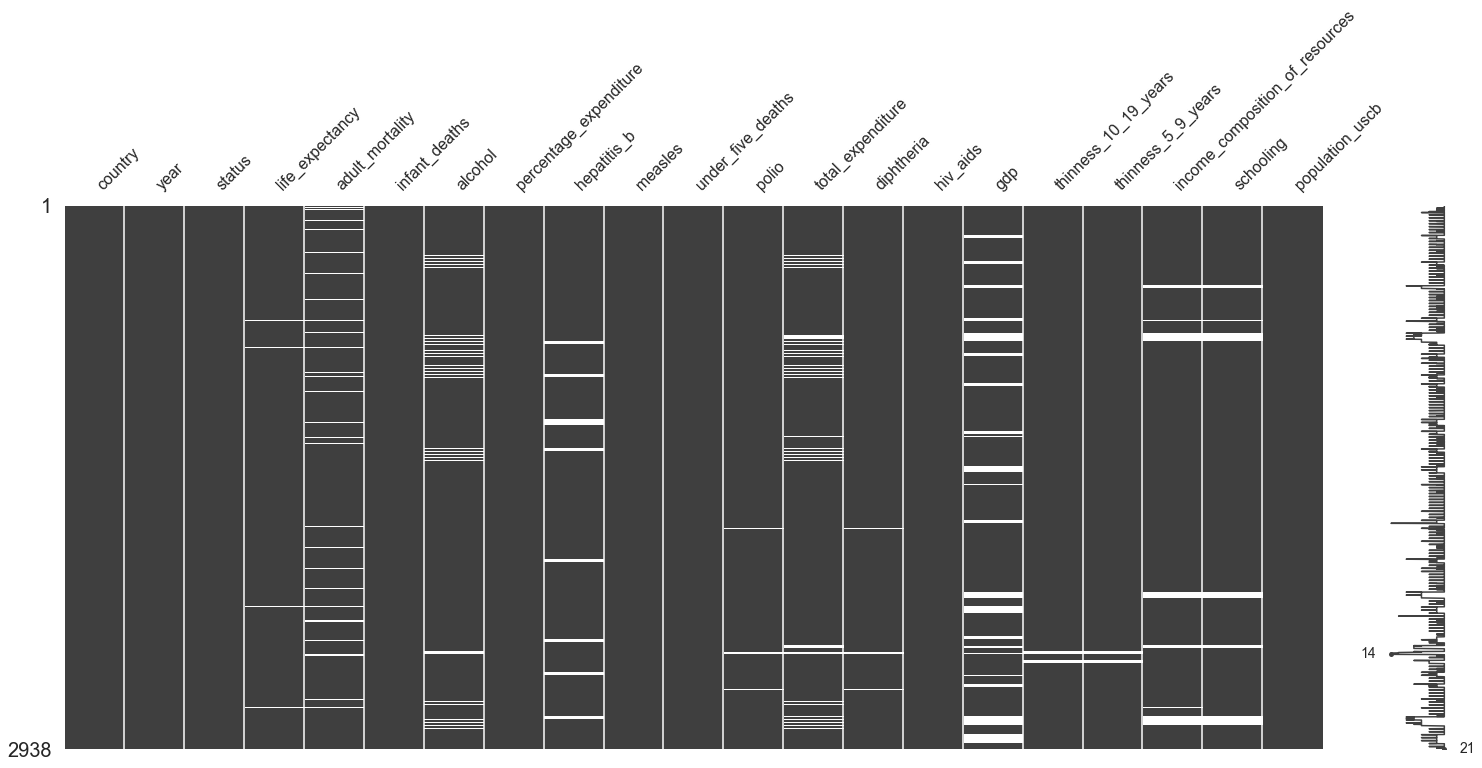

In [32]:
# For Algeria, filling in the NaNs using mean() and interpolate() results in similar values for the missing years (78 and 81)
# However, for Bangladesh, there seems to be a real time-series trend and mean and interpolate give very different values (77 and 5)
# Interpolation seems to be the best method. So go ahead and fill missing values using interpolation for EACH country and visualize using missingno
for country in countries:
    df.loc[df['country'] == country, 'hepatitis_b'] = df.loc[df['country'] == country, 'hepatitis_b'].interpolate()

msno.matrix(df)

In [33]:
# There are 9 remaining countries with full (16 years) missingness
# We will go ahead and fill these using column-based hepatitis_b mean value
df['hepatitis_b'] = df['hepatitis_b'].fillna(df['hepatitis_b'].mean())

***
### GDP
***

In [34]:
# Run similar analysis for GDP
# Execute null_counter function
null_counter('gdp')

gdp missing value count: 0		Afghanistan
gdp missing value count: 0		Albania
gdp missing value count: 0		Algeria
gdp missing value count: 16		Côte d'Ivoire
gdp missing value count: 0		Angola
gdp missing value count: 0		Antigua and Barbuda
gdp missing value count: 0		Argentina
gdp missing value count: 0		Armenia
gdp missing value count: 0		Australia
gdp missing value count: 0		Austria
gdp missing value count: 0		Azerbaijan
gdp missing value count: 16		Bahamas
gdp missing value count: 0		Bahrain
gdp missing value count: 0		Bangladesh
gdp missing value count: 0		Barbados
gdp missing value count: 0		Belarus
gdp missing value count: 0		Belgium
gdp missing value count: 0		Belize
gdp missing value count: 0		Benin
gdp missing value count: 0		Bhutan
gdp missing value count: 16		Bolivia (Plurinational State of)
gdp missing value count: 0		Bosnia and Herzegovina
gdp missing value count: 0		Botswana
gdp missing value count: 0		Brazil
gdp missing value count: 0		Brunei Darussalam
gdp missing value c

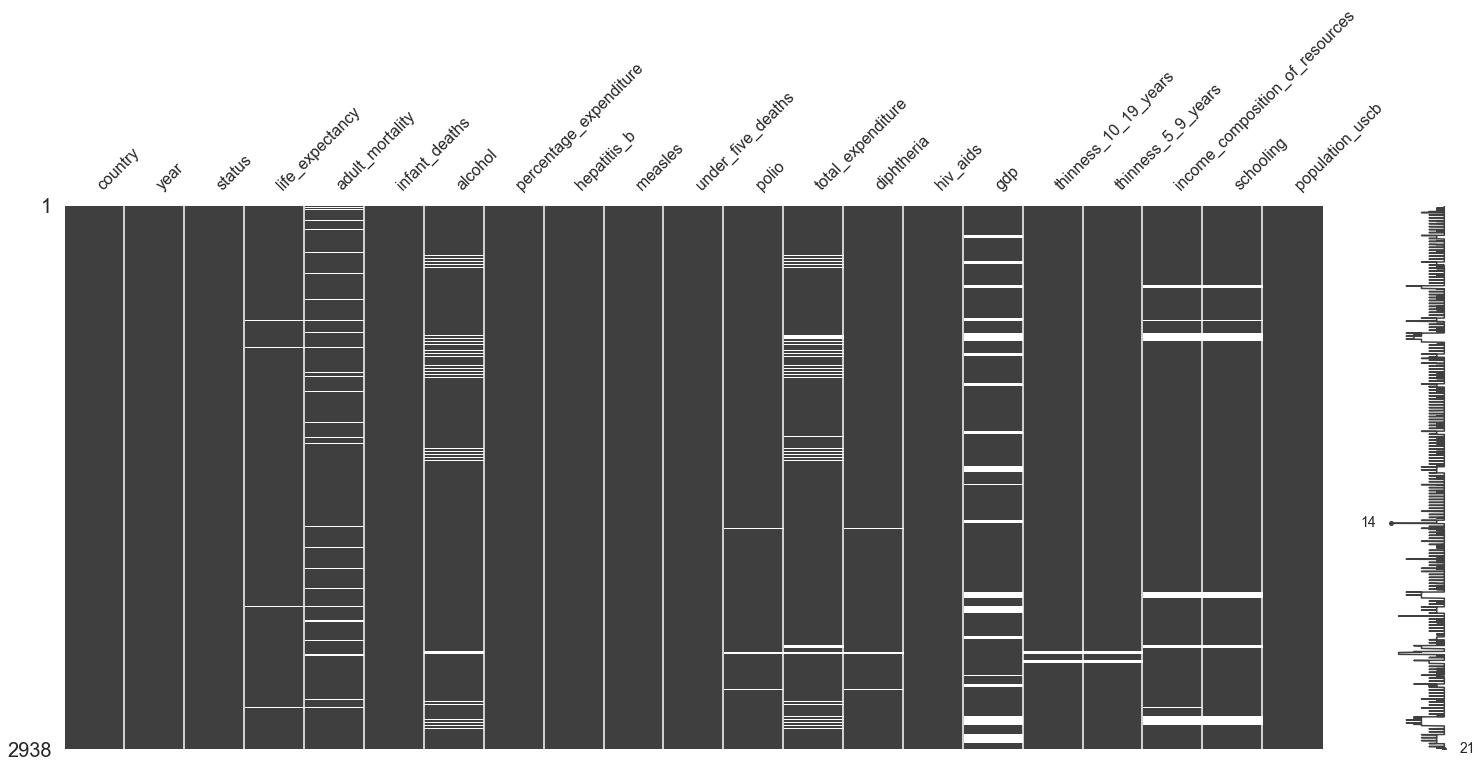

In [35]:
# Slightly different situaiton. GDP is almost either entirely filled or entirely missing across countries. 
# Go ahead and interpolate for the few countries that have >0 or <16 missing values
for country in countries:
    df.loc[df['country'] == country, 'gdp'] = df.loc[df['country'] == country, 'gdp'].interpolate()

msno.matrix(df)

In [36]:
# There are tens of remaining countries with full (16 years) missingness
# We will go ahead and fill these using column-based gdp mean value
# Note at this point, both hepatitis_b and gdp cannot be compared between countries due to the fillna() with column means
df['gdp'] = df['gdp'].fillna(df['gdp'].mean())

***
### Alcohol and Total Expenditure
***

In [37]:
# Remembering that missingness between these two variables was highly correlated (+0.9)
# Execute null_counter function
null_counter('alcohol')

alcohol missing value count: 0		Afghanistan
alcohol missing value count: 0		Albania
alcohol missing value count: 1		Algeria
alcohol missing value count: 1		Côte d'Ivoire
alcohol missing value count: 1		Angola
alcohol missing value count: 1		Antigua and Barbuda
alcohol missing value count: 1		Argentina
alcohol missing value count: 1		Armenia
alcohol missing value count: 1		Australia
alcohol missing value count: 1		Austria
alcohol missing value count: 1		Azerbaijan
alcohol missing value count: 1		Bahamas
alcohol missing value count: 1		Bahrain
alcohol missing value count: 1		Bangladesh
alcohol missing value count: 1		Barbados
alcohol missing value count: 1		Belarus
alcohol missing value count: 1		Belgium
alcohol missing value count: 1		Belize
alcohol missing value count: 1		Benin
alcohol missing value count: 1		Bhutan
alcohol missing value count: 1		Bolivia (Plurinational State of)
alcohol missing value count: 1		Bosnia and Herzegovina
alcohol missing value count: 1		Botswana
alcohol mis

In [38]:
null_counter('total_expenditure')

total_expenditure missing value count: 0		Afghanistan
total_expenditure missing value count: 0		Albania
total_expenditure missing value count: 1		Algeria
total_expenditure missing value count: 1		Côte d'Ivoire
total_expenditure missing value count: 1		Angola
total_expenditure missing value count: 1		Antigua and Barbuda
total_expenditure missing value count: 1		Argentina
total_expenditure missing value count: 1		Armenia
total_expenditure missing value count: 1		Australia
total_expenditure missing value count: 1		Austria
total_expenditure missing value count: 1		Azerbaijan
total_expenditure missing value count: 1		Bahamas
total_expenditure missing value count: 1		Bahrain
total_expenditure missing value count: 1		Bangladesh
total_expenditure missing value count: 1		Barbados
total_expenditure missing value count: 1		Belarus
total_expenditure missing value count: 1		Belgium
total_expenditure missing value count: 1		Belize
total_expenditure missing value count: 1		Benin
total_expenditure mis

total_expenditure missing value count: 1		Tajikistan
total_expenditure missing value count: 1		Thailand
total_expenditure missing value count: 1		The former Yugoslav republic of Macedonia
total_expenditure missing value count: 1		Timor-Leste
total_expenditure missing value count: 1		Togo
total_expenditure missing value count: 1		Tonga
total_expenditure missing value count: 1		Trinidad and Tobago
total_expenditure missing value count: 1		Tunisia
total_expenditure missing value count: 1		Turkey
total_expenditure missing value count: 1		Turkmenistan
total_expenditure missing value count: 0		Tuvalu
total_expenditure missing value count: 1		Uganda
total_expenditure missing value count: 1		Ukraine
total_expenditure missing value count: 1		United Arab Emirates
total_expenditure missing value count: 1		United Kingdom of Great Britain and Northern Ireland
total_expenditure missing value count: 1		United Republic of Tanzania
total_expenditure missing value count: 1		United States of America
tota

In [39]:
# For the most part, it appears that alcohol and total_expenditure both have one value missing for each country, and the year is commonly 2015.
# See example for 'Bulgaria' below
df.loc[df['country']=='Bulgaria', ['country', 'year', 'alcohol']]

,country,year,alcohol
385,Bulgaria,2015,NaN
386,Bulgaria,2014,12.03
387,Bulgaria,2013,12.06
388,Bulgaria,2012,10.99
389,Bulgaria,2011,10.67
390,Bulgaria,2010,10.80
391,Bulgaria,2009,10.93
392,Bulgaria,2008,10.98
393,Bulgaria,2007,10.89
394,Bulgaria,2006,10.39


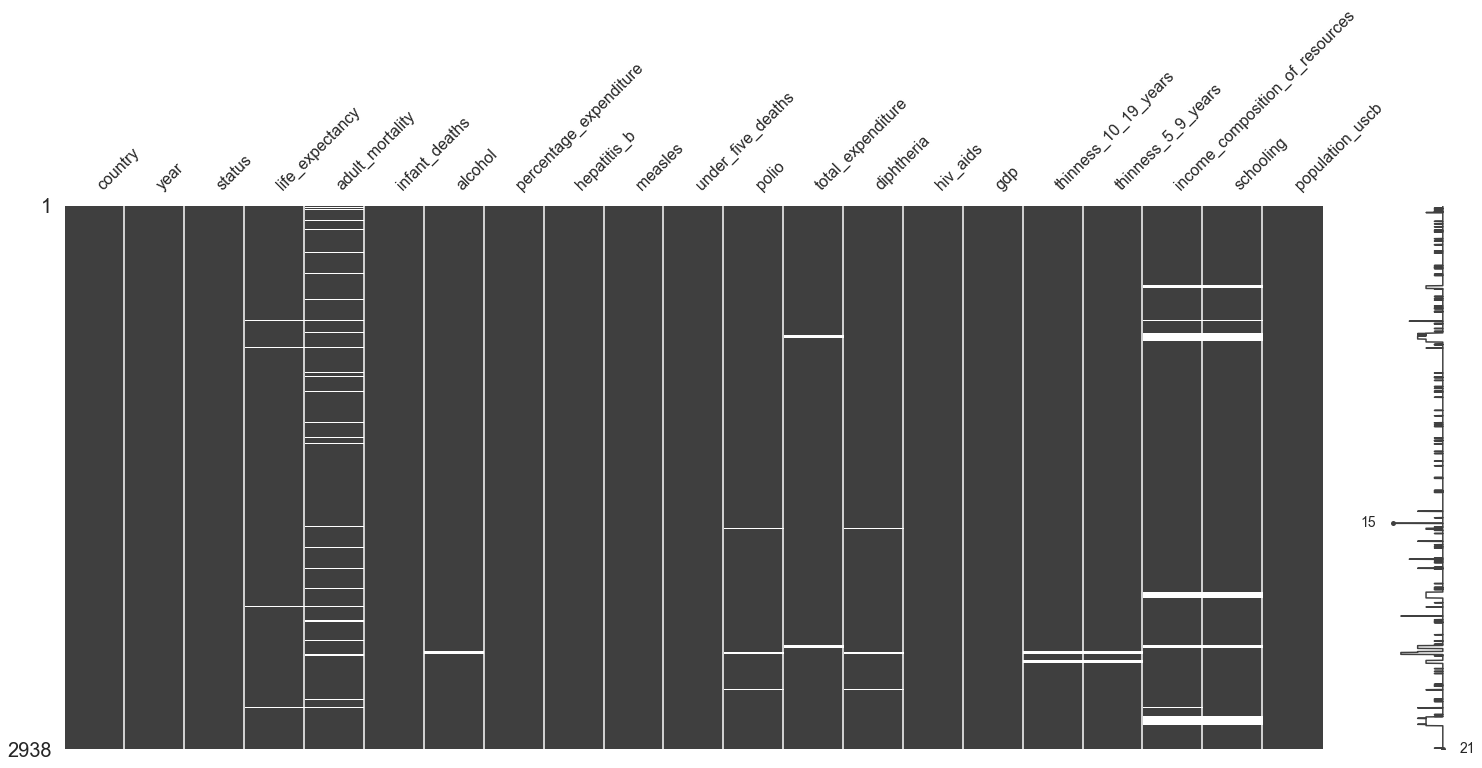

In [40]:
# Go ahead and interpolate for both alcohol and total_expenditure and then visualize
var_list = ['alcohol', 'total_expenditure']
for country in countries:
    df.loc[df['country']==country, var_list] = df.loc[df['country']==country, var_list].interpolate(limit_direction = 'both')

msno.matrix(df)

In [41]:
# Check interpolation for alcohol in Bulgaria 
df.loc[df['country']=='Bulgaria', ['country', 'year', 'alcohol']]

,country,year,alcohol
385,Bulgaria,2015,12.03
386,Bulgaria,2014,12.03
387,Bulgaria,2013,12.06
388,Bulgaria,2012,10.99
389,Bulgaria,2011,10.67
390,Bulgaria,2010,10.80
391,Bulgaria,2009,10.93
392,Bulgaria,2008,10.98
393,Bulgaria,2007,10.89
394,Bulgaria,2006,10.39


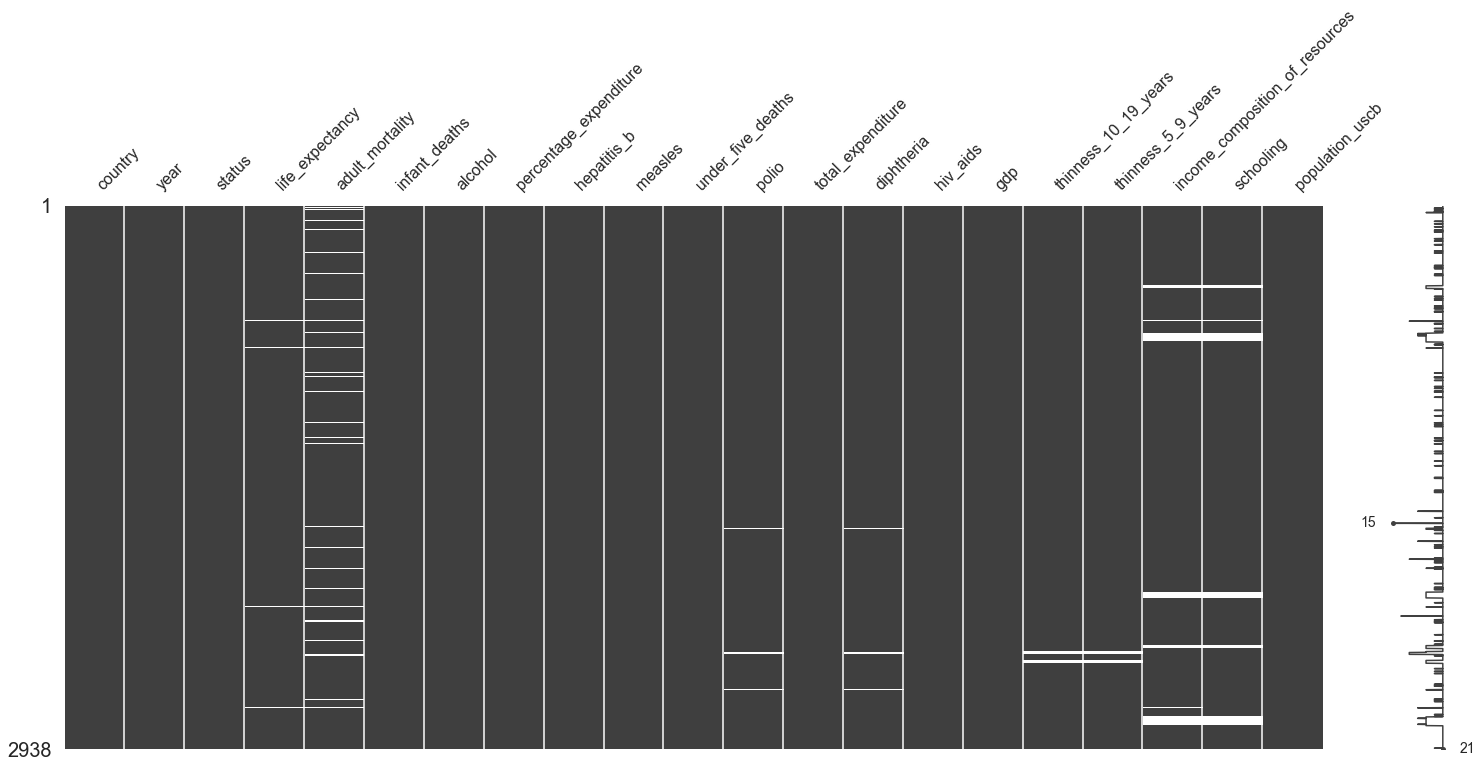

In [42]:
# Fill remaining alcohol and total_expenditure missing values with their column means()
df[var_list] = df[var_list].fillna(df[var_list].mean())
msno.matrix(df)

***
### Adult Mortality
***

In [43]:
null_counter('adult_mortality')

adult_mortality missing value count: 1		Afghanistan
adult_mortality missing value count: 4		Albania
adult_mortality missing value count: 1		Algeria
adult_mortality missing value count: 0		Côte d'Ivoire
adult_mortality missing value count: 0		Angola
adult_mortality missing value count: 0		Antigua and Barbuda
adult_mortality missing value count: 2		Argentina
adult_mortality missing value count: 1		Armenia
adult_mortality missing value count: 1		Australia
adult_mortality missing value count: 3		Austria
adult_mortality missing value count: 0		Azerbaijan
adult_mortality missing value count: 0		Bahamas
adult_mortality missing value count: 3		Bahrain
adult_mortality missing value count: 0		Bangladesh
adult_mortality missing value count: 3		Barbados
adult_mortality missing value count: 0		Belarus
adult_mortality missing value count: 3		Belgium
adult_mortality missing value count: 0		Belize
adult_mortality missing value count: 0		Benin
adult_mortality missing value count: 0		Bhutan
adult_mortal

adult_mortality missing value count: 1		United States of America
adult_mortality missing value count: 0		Uruguay
adult_mortality missing value count: 0		Uzbekistan
adult_mortality missing value count: 0		Vanuatu
adult_mortality missing value count: 0		Venezuela (Bolivarian Republic of)
adult_mortality missing value count: 0		Viet Nam
adult_mortality missing value count: 0		Yemen
adult_mortality missing value count: 0		Zambia
adult_mortality missing value count: 1		Zimbabwe


In [44]:
## Interpolate by country. Most have 0 or a few missed entries, and no country has a full complement of missing rows
for country in countries:
    df.loc[df['country']==country, 'adult_mortality'] = df.loc[df['country']==country, 'adult_mortality'].interpolate(limit_direction = 'both')

***
### Schooling and income composition of resources
***

In [45]:
# Remembering that missingness between these two variables was 100% correlated 
# Execute null_counter function
null_counter('schooling')

schooling missing value count: 0		Afghanistan
schooling missing value count: 0		Albania
schooling missing value count: 0		Algeria
schooling missing value count: 16		Côte d'Ivoire
schooling missing value count: 0		Angola
schooling missing value count: 0		Antigua and Barbuda
schooling missing value count: 0		Argentina
schooling missing value count: 0		Armenia
schooling missing value count: 0		Australia
schooling missing value count: 0		Austria
schooling missing value count: 0		Azerbaijan
schooling missing value count: 0		Bahamas
schooling missing value count: 0		Bahrain
schooling missing value count: 0		Bangladesh
schooling missing value count: 0		Barbados
schooling missing value count: 0		Belarus
schooling missing value count: 0		Belgium
schooling missing value count: 0		Belize
schooling missing value count: 0		Benin
schooling missing value count: 0		Bhutan
schooling missing value count: 0		Bolivia (Plurinational State of)
schooling missing value count: 0		Bosnia and Herzegovina
schooli

In [46]:
null_counter('income_composition_of_resources')

income_composition_of_resources missing value count: 0		Afghanistan
income_composition_of_resources missing value count: 0		Albania
income_composition_of_resources missing value count: 0		Algeria
income_composition_of_resources missing value count: 16		Côte d'Ivoire
income_composition_of_resources missing value count: 0		Angola
income_composition_of_resources missing value count: 0		Antigua and Barbuda
income_composition_of_resources missing value count: 0		Argentina
income_composition_of_resources missing value count: 0		Armenia
income_composition_of_resources missing value count: 0		Australia
income_composition_of_resources missing value count: 0		Austria
income_composition_of_resources missing value count: 0		Azerbaijan
income_composition_of_resources missing value count: 0		Bahamas
income_composition_of_resources missing value count: 0		Bahrain
income_composition_of_resources missing value count: 0		Bangladesh
income_composition_of_resources missing value count: 0		Barbados
income_

income_composition_of_resources missing value count: 1		Niue
income_composition_of_resources missing value count: 0		Norway
income_composition_of_resources missing value count: 0		Oman
income_composition_of_resources missing value count: 0		Pakistan
income_composition_of_resources missing value count: 0		Palau
income_composition_of_resources missing value count: 0		Panama
income_composition_of_resources missing value count: 0		Papua New Guinea
income_composition_of_resources missing value count: 0		Paraguay
income_composition_of_resources missing value count: 0		Peru
income_composition_of_resources missing value count: 0		Philippines
income_composition_of_resources missing value count: 0		Poland
income_composition_of_resources missing value count: 0		Portugal
income_composition_of_resources missing value count: 0		Qatar
income_composition_of_resources missing value count: 16		Republic of Korea
income_composition_of_resources missing value count: 16		Republic of Moldova
income_compositi

In [47]:
## These variables are either characterized by missingness for all 2000-2015 years, or have 1 missing entry.
## What are the ones?
ones_list = []
for country in countries:
    tmp = df[(df['income_composition_of_resources'].isnull() == True)&(df['country']==country)][['country']].count()
    tmp2 = df[(df['schooling'].isnull() == True)&(df['country']==country)][['country']].count()
    if tmp['country']==1:
        print(country + ': income_composition_of_resources')
    if tmp2['country']==1:
        print(country + ': schooling')

Cook Islands: income_composition_of_resources
Cook Islands: schooling
Marshall Islands: income_composition_of_resources
Monaco: income_composition_of_resources
Monaco: schooling
Nauru: income_composition_of_resources
Niue: income_composition_of_resources
Niue: schooling
San Marino: income_composition_of_resources
Tuvalu: income_composition_of_resources


In [48]:
df[(df['country']=='Cook Islands')|(df['country']=='Tuvalu')|(df['country']=='Monaco')]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling,population_uscb
624,Cook Islands,2013,Developing,NaN,NaN,42.460658,0.01,0.000000,98.0,0,...,98.0,3.58,98.0,0.1,7413.645004,0.1,0.1,NaN,NaN,10447.0
1716,Monaco,2013,Developing,NaN,NaN,42.460658,0.01,0.000000,99.0,0,...,99.0,4.30,99.0,0.1,7413.645004,NaN,NaN,NaN,NaN,30500.0
2713,Tuvalu,2013,Developing,NaN,NaN,42.460658,0.01,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,0.2,0.1,NaN,0.0,10698.0


In [49]:
# So these countries have only one entry, for 2013 it seems. Interpolation not possible.
# Treat these the same as countries that have full missingness for schooling and income_composition_of_resources (i.e. use column mean)
var_list = ['schooling', 'income_composition_of_resources']
df[var_list] = df[var_list].fillna(df[var_list].mean())

***
### Thinness variables
***

In [50]:
# Again, both variables are 100% correlated
# Excute null_counter
null_counter('thinness_10_19_years')

thinness_10_19_years missing value count: 0		Afghanistan
thinness_10_19_years missing value count: 0		Albania
thinness_10_19_years missing value count: 0		Algeria
thinness_10_19_years missing value count: 0		Côte d'Ivoire
thinness_10_19_years missing value count: 0		Angola
thinness_10_19_years missing value count: 0		Antigua and Barbuda
thinness_10_19_years missing value count: 0		Argentina
thinness_10_19_years missing value count: 0		Armenia
thinness_10_19_years missing value count: 0		Australia
thinness_10_19_years missing value count: 0		Austria
thinness_10_19_years missing value count: 0		Azerbaijan
thinness_10_19_years missing value count: 0		Bahamas
thinness_10_19_years missing value count: 0		Bahrain
thinness_10_19_years missing value count: 0		Bangladesh
thinness_10_19_years missing value count: 0		Barbados
thinness_10_19_years missing value count: 0		Belarus
thinness_10_19_years missing value count: 0		Belgium
thinness_10_19_years missing value count: 0		Belize
thinness_10_19_

thinness_10_19_years missing value count: 0		Seychelles
thinness_10_19_years missing value count: 0		Sierra Leone
thinness_10_19_years missing value count: 0		Singapore
thinness_10_19_years missing value count: 0		Slovenia
thinness_10_19_years missing value count: 0		Solomon Islands
thinness_10_19_years missing value count: 0		Somalia
thinness_10_19_years missing value count: 0		South Africa
thinness_10_19_years missing value count: 16		South Sudan
thinness_10_19_years missing value count: 0		Spain
thinness_10_19_years missing value count: 0		Sri Lanka
thinness_10_19_years missing value count: 16		Sudan
thinness_10_19_years missing value count: 0		Suriname
thinness_10_19_years missing value count: 0		Swaziland
thinness_10_19_years missing value count: 0		Sweden
thinness_10_19_years missing value count: 0		Switzerland
thinness_10_19_years missing value count: 0		Syrian Arab Republic
thinness_10_19_years missing value count: 0		Tajikistan
thinness_10_19_years missing value count: 0		Thai

In [51]:
# San Marino, South Sudan and Sudan both have full missingness for all three variables
# Go ahead and use column means to fill the NaNs
var_list = ['thinness_10_19_years', 'thinness_5_9_years']
df[var_list] = df[var_list].fillna(df[var_list].mean())

***
### Polio and Diphtheria
***

In [52]:
# 100% correlated in terms of missingness
null_counter('polio')

polio missing value count: 0		Afghanistan
polio missing value count: 0		Albania
polio missing value count: 0		Algeria
polio missing value count: 0		Côte d'Ivoire
polio missing value count: 0		Angola
polio missing value count: 0		Antigua and Barbuda
polio missing value count: 0		Argentina
polio missing value count: 0		Armenia
polio missing value count: 0		Australia
polio missing value count: 0		Austria
polio missing value count: 0		Azerbaijan
polio missing value count: 0		Bahamas
polio missing value count: 0		Bahrain
polio missing value count: 0		Bangladesh
polio missing value count: 0		Barbados
polio missing value count: 0		Belarus
polio missing value count: 0		Belgium
polio missing value count: 0		Belize
polio missing value count: 0		Benin
polio missing value count: 0		Bhutan
polio missing value count: 0		Bolivia (Plurinational State of)
polio missing value count: 0		Bosnia and Herzegovina
polio missing value count: 0		Botswana
polio missing value count: 0		Brazil
polio missing value 

In [53]:
# Montenegro, South Sudan, and Timor-Leste contain NaNs for polio and diphtheria
# We can go ahead and interpolate these columns for each country
var_list = ['polio', 'diphtheria']
for country in countries:
    df.loc[df['country']==country, var_list] = df.loc[df['country']==country, var_list].interpolate(limit_direction = 'both')

***
### Life expectancy
***

In [54]:
# Life expectancy is our target variable. We probably do not want to fill these values with an imputation
# Check countries for missingness first: variables are 100% correlated in terms of missingness
null_counter('life_expectancy')

life_expectancy missing value count: 0		Afghanistan
life_expectancy missing value count: 0		Albania
life_expectancy missing value count: 0		Algeria
life_expectancy missing value count: 0		Côte d'Ivoire
life_expectancy missing value count: 0		Angola
life_expectancy missing value count: 0		Antigua and Barbuda
life_expectancy missing value count: 0		Argentina
life_expectancy missing value count: 0		Armenia
life_expectancy missing value count: 0		Australia
life_expectancy missing value count: 0		Austria
life_expectancy missing value count: 0		Azerbaijan
life_expectancy missing value count: 0		Bahamas
life_expectancy missing value count: 0		Bahrain
life_expectancy missing value count: 0		Bangladesh
life_expectancy missing value count: 0		Barbados
life_expectancy missing value count: 0		Belarus
life_expectancy missing value count: 0		Belgium
life_expectancy missing value count: 0		Belize
life_expectancy missing value count: 0		Benin
life_expectancy missing value count: 0		Bhutan
life_expecta

life_expectancy missing value count: 0		Turkey
life_expectancy missing value count: 0		Turkmenistan
life_expectancy missing value count: 1		Tuvalu
life_expectancy missing value count: 0		Uganda
life_expectancy missing value count: 0		Ukraine
life_expectancy missing value count: 0		United Arab Emirates
life_expectancy missing value count: 0		United Kingdom of Great Britain and Northern Ireland
life_expectancy missing value count: 0		United Republic of Tanzania
life_expectancy missing value count: 0		United States of America
life_expectancy missing value count: 0		Uruguay
life_expectancy missing value count: 0		Uzbekistan
life_expectancy missing value count: 0		Vanuatu
life_expectancy missing value count: 0		Venezuela (Bolivarian Republic of)
life_expectancy missing value count: 0		Viet Nam
life_expectancy missing value count: 0		Yemen
life_expectancy missing value count: 0		Zambia
life_expectancy missing value count: 0		Zimbabwe


In [55]:
# What are the entries?
df[df['life_expectancy'].isnull() == True]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling,population_uscb
624,Cook Islands,2013,Developing,NaN,NaN,42.460658,0.010000,0.000000,98.0,0,...,98.0,3.58,98.0,0.1,7413.645004,0.100000,0.100000,0.627551,11.992793,10447.0
769,Dominica,2013,Developing,NaN,NaN,42.460658,0.010000,11.419555,96.0,0,...,96.0,5.58,96.0,0.1,722.756650,2.700000,2.600000,0.721000,12.700000,73286.0
1651,Marshall Islands,2013,Developing,NaN,NaN,42.460658,0.010000,871.878317,8.0,0,...,79.0,17.24,79.0,0.1,3617.752354,0.100000,0.100000,0.627551,0.000000,69747.0
1716,Monaco,2013,Developing,NaN,NaN,42.460658,0.010000,0.000000,99.0,0,...,99.0,4.30,99.0,0.1,7413.645004,4.839704,4.870317,0.627551,11.992793,30500.0
1813,Nauru,2013,Developing,NaN,NaN,42.460658,0.010000,15.606596,87.0,0,...,87.0,4.65,87.0,0.1,136.183210,0.100000,0.100000,0.627551,9.600000,9434.0
1910,Niue,2013,Developing,NaN,NaN,42.460658,0.010000,0.000000,99.0,0,...,99.0,7.20,99.0,0.1,7413.645004,0.100000,0.100000,0.627551,11.992793,1620.0
1959,Palau,2013,Developing,NaN,NaN,42.460658,4.518331,344.690631,99.0,0,...,99.0,9.27,99.0,0.1,1932.122370,0.100000,0.100000,0.779000,14.200000,21108.0
2168,Saint Kitts and Nevis,2013,Developing,NaN,NaN,42.460658,8.540000,0.000000,97.0,0,...,96.0,6.14,96.0,0.1,7413.645004,3.700000,3.600000,0.749000,13.400000,51134.0
2217,San Marino,2013,Developing,NaN,NaN,42.460658,0.010000,0.000000,69.0,0,...,69.0,6.50,69.0,0.1,7413.645004,4.839704,4.870317,0.627551,15.100000,32448.0
2713,Tuvalu,2013,Developing,NaN,NaN,42.460658,0.010000,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,0.200000,0.100000,0.627551,0.000000,10698.0


In [56]:
# We should drop these rows as we are dealing with the target variable
df = df[df['life_expectancy'].isnull() == False]

How are we looking? From a initial possible 2938 rows and 22 columns, we now have 2928 rows and 21 (dropped 'bmi') columns as shown below.

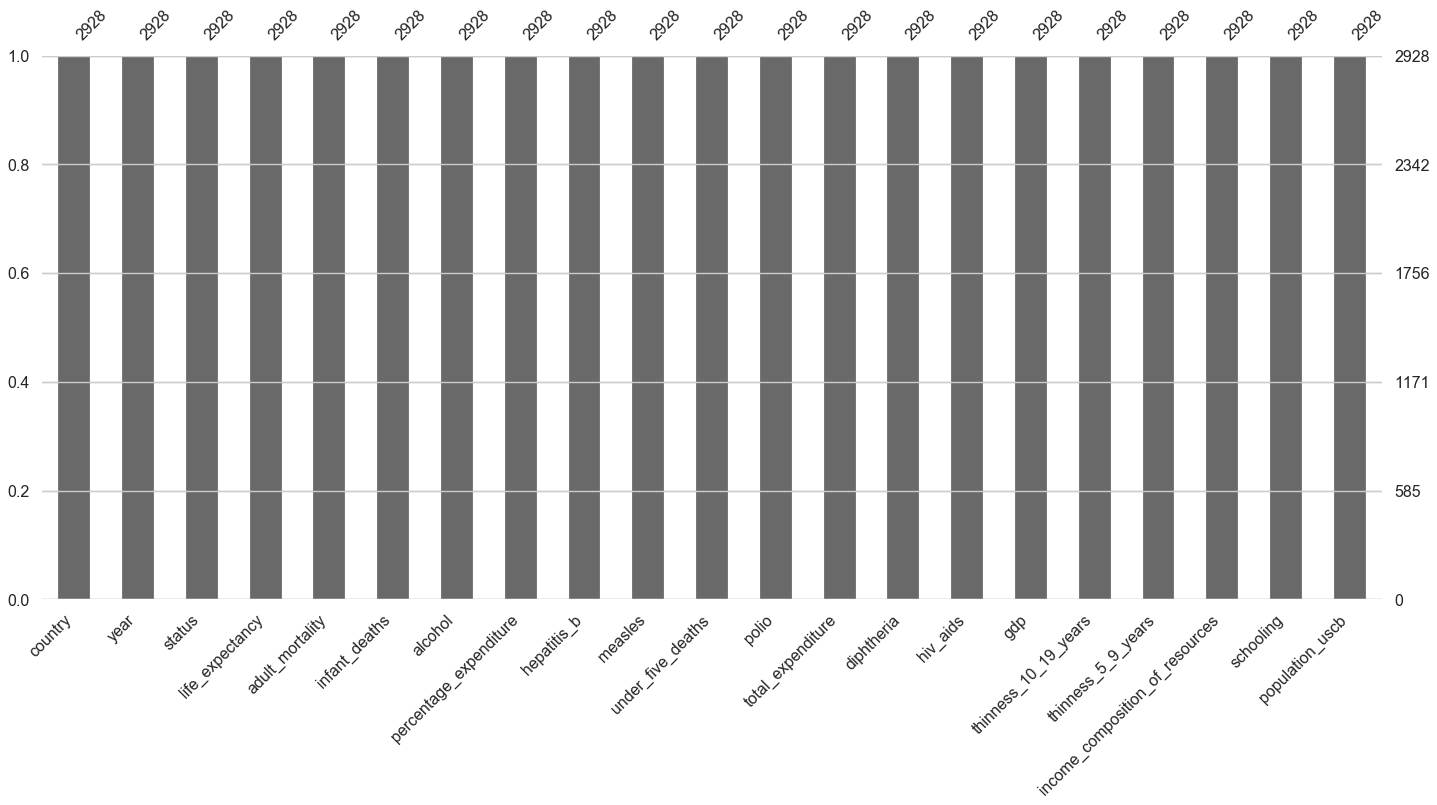

In [57]:
msno.bar(df)

In [58]:
df_to_eda(df)

,null_sum,null_%,dtypes,count,mean,median,min,max
adult_mortality,0,0.0,float64,2928,1.685891e+02,1.440000e+02,13,723
alcohol,0,0.0,float64,2928,4.529275e+00,3.650000e+00,0.01,17.87
country,0,0.0,object,2928,NaN,NaN,Afghanistan,Zimbabwe
diphtheria,0,0.0,float64,2928,8.207172e+01,9.300000e+01,2,99
gdp,0,0.0,float64,2928,7.422906e+03,2.861855e+03,1.68135,119173
hepatitis_b,0,0.0,float64,2928,7.583230e+01,8.800000e+01,1,99
hiv_aids,0,0.0,float64,2928,1.747712e+00,1.000000e-01,0.1,50.6
income_composition_of_resources,0,0.0,float64,2928,6.274259e-01,6.620000e-01,0,0.948
infant_deaths,0,0.0,float64,2928,4.246066e+01,2.700000e+01,1,1800
life_expectancy,0,0.0,float64,2928,6.922493e+01,7.210000e+01,36.3,89


***
## Outlier Detection/Treatment
***

In [59]:
#df.columns
var_list = ['life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'thinness_10_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'population_uscb']

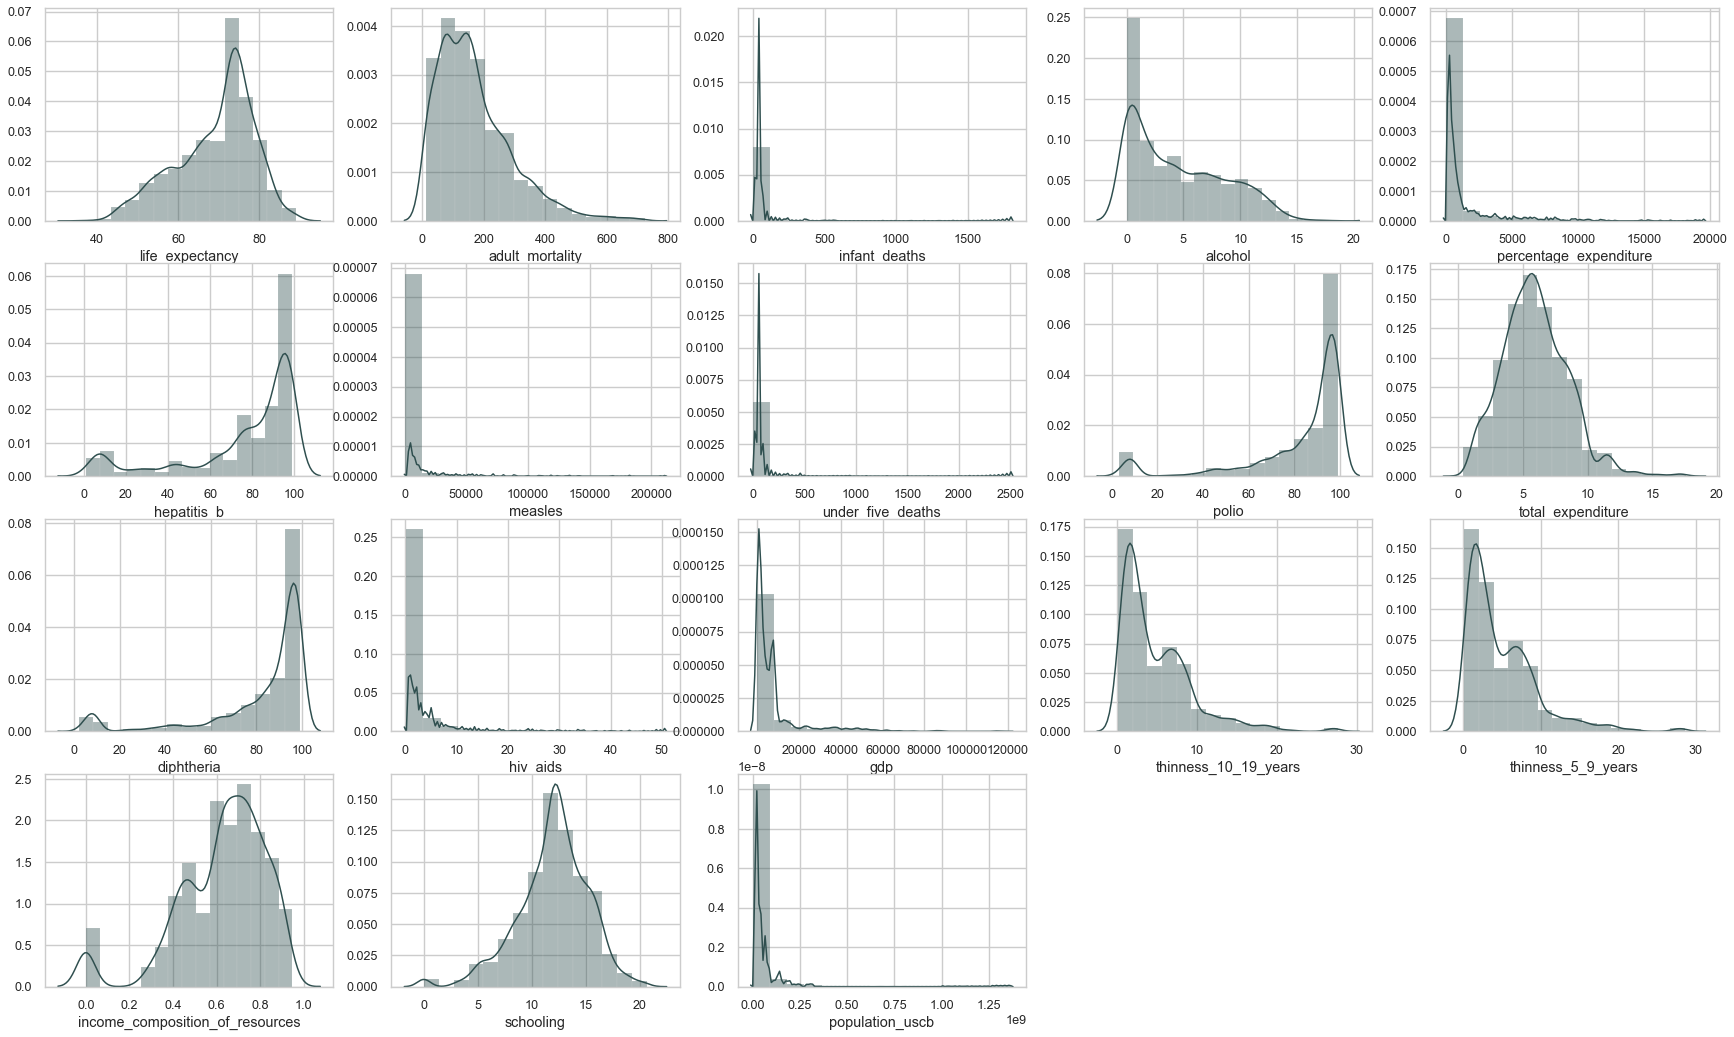

In [60]:
# Histogram distributions
def histoplot(data, panel):
    plt.subplot(4,5,panel)
    sns.distplot(data, bins=15, color='darkslategrey')

fig = plt.figure(figsize=(30,18))
for ii,jj in enumerate(var_list):
    histoplot(df[jj], ii+1)

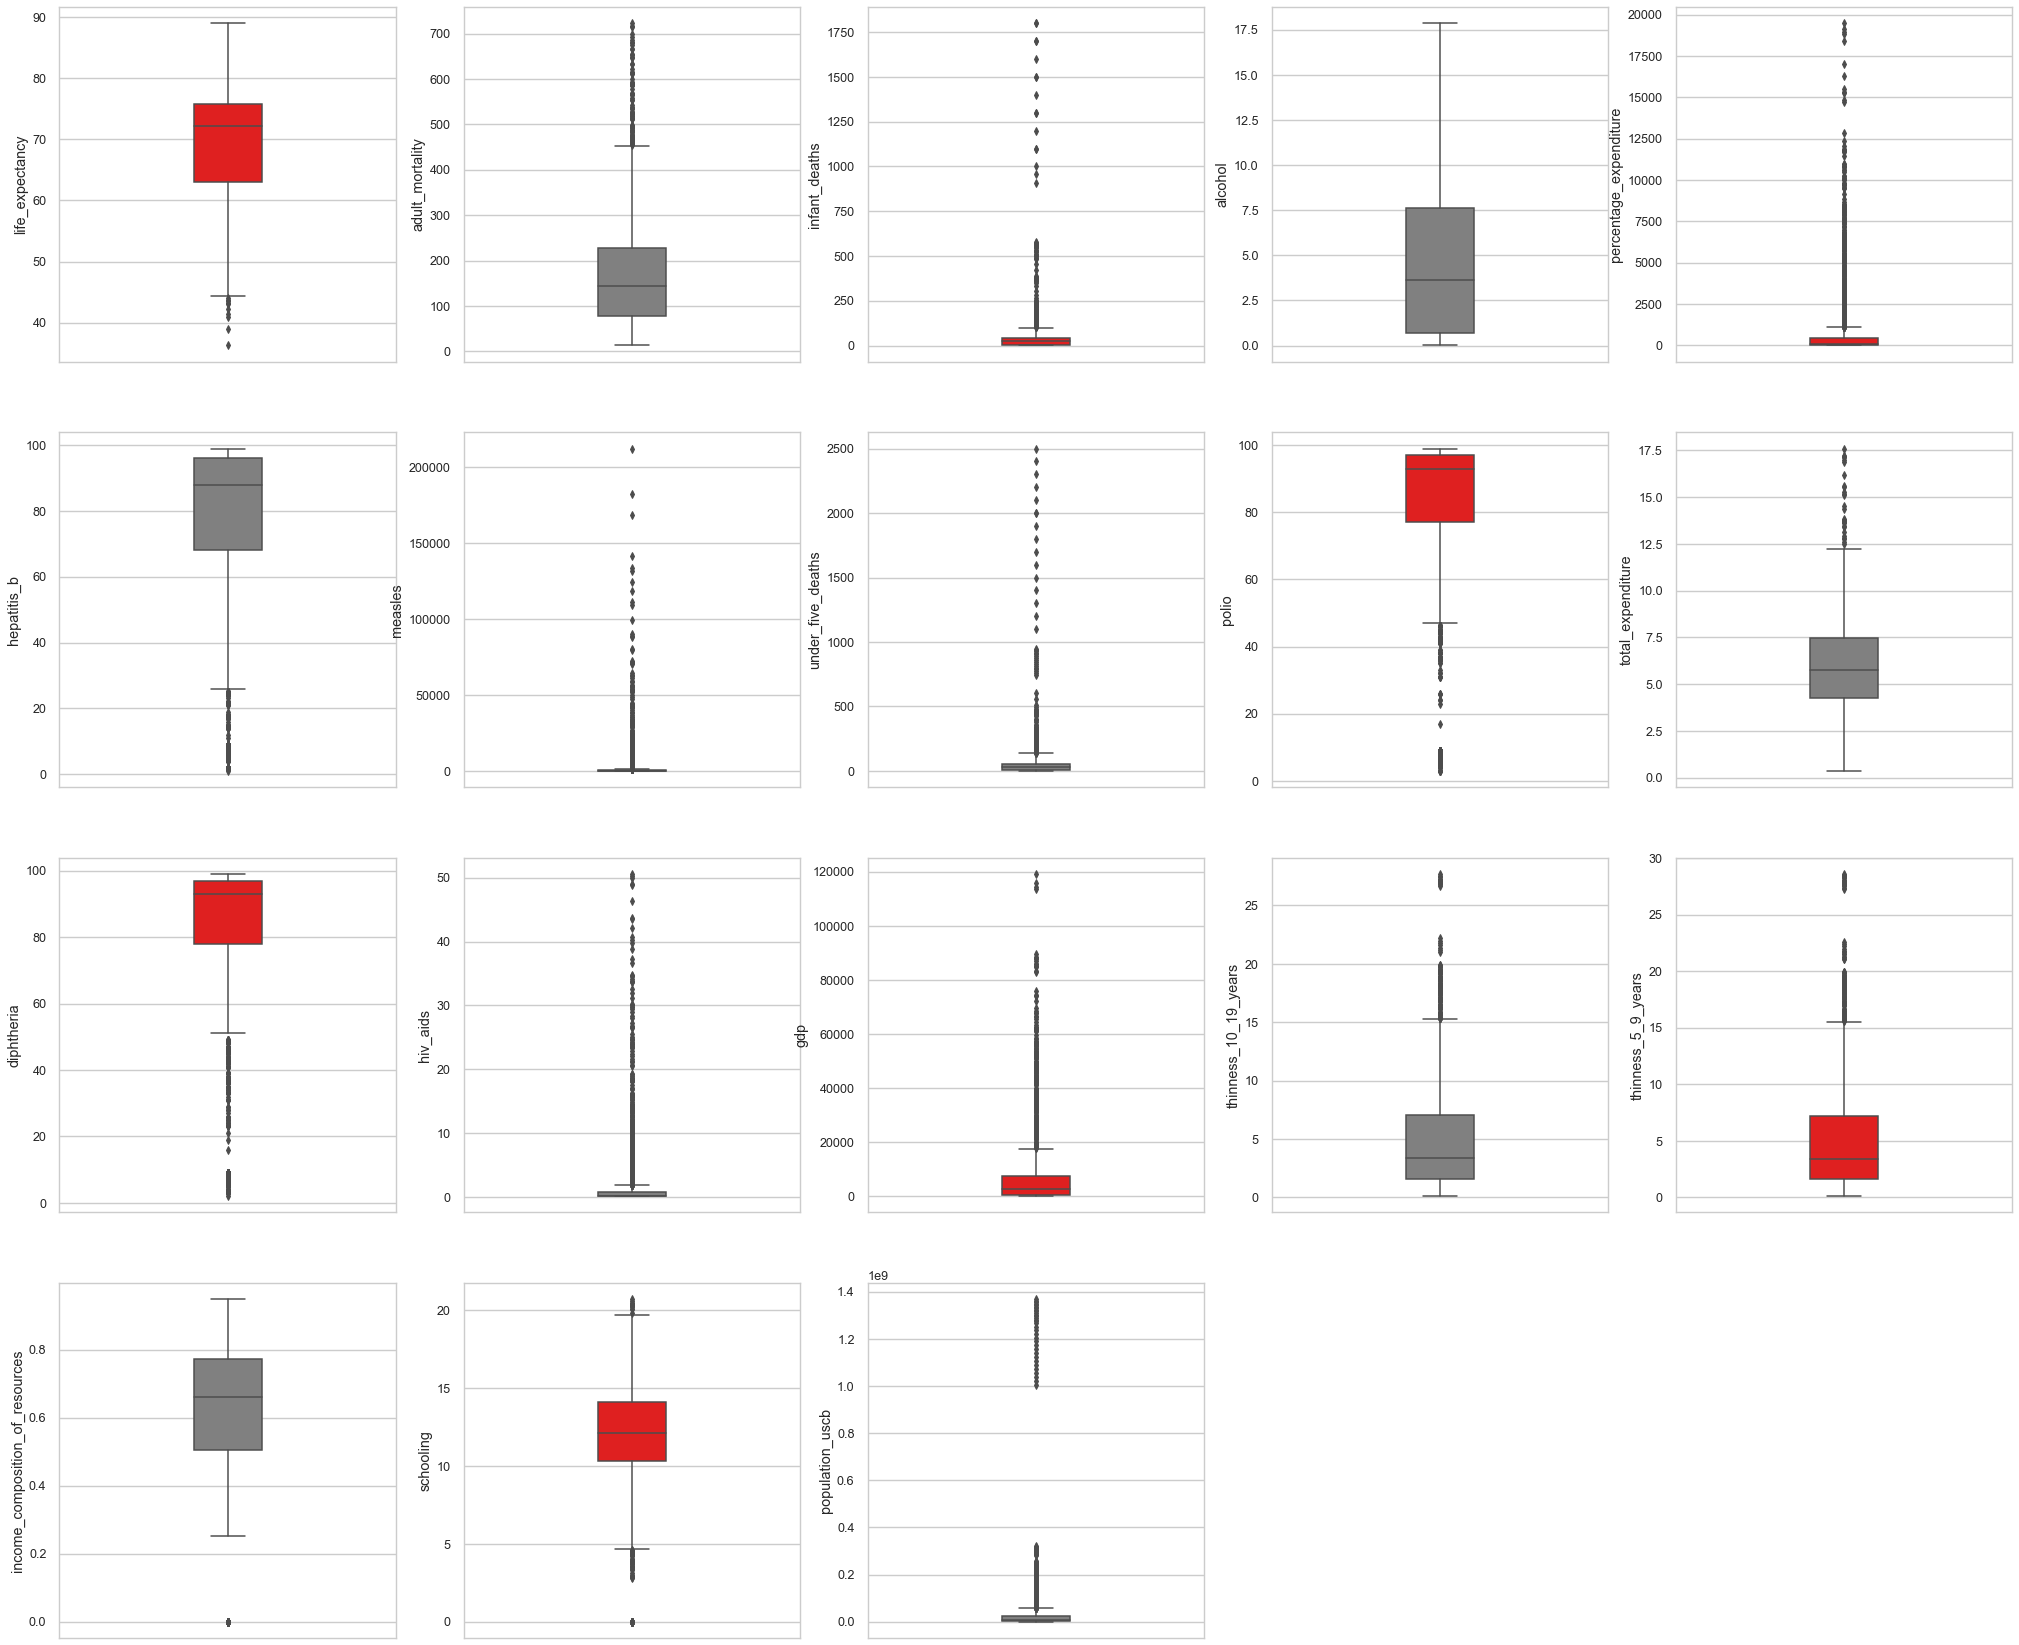

In [61]:
# Boxplots 
def boxplotter(data, panel):
    plt.subplot(4,5,panel)
    if np.mod(panel,2) == 0:
        f = sns.boxplot(y = data, color = 'grey')
    else:
        f = sns.boxplot(y = data, color = 'red')    
    f.set_xlim(-2,2)
    
fig2 = plt.figure(figsize=(35,30))
for ii,jj in enumerate(var_list):
    boxplotter(df[jj], ii+1)

All variables display significant outliers as detected by their histogram distributions and box plots.</br>

Let's look at this further using Tukey's interquartile range (IQR) method, setting the threshold to 1.5

In [62]:
## Define function for IQR method
def tukey_iqr(data, threshold):
    q75, q25 = np.percentile(data, [75,25])
    iqr = q75-q25
    min_iqr = q25 - (iqr*threshold)
    max_iqr = q75 + (iqr*threshold)
    n_outliers = len((np.where((data>max_iqr) | (data<min_iqr)))[0])
    print('Variable = {}: \nIQR outliers fraction = {} %'.format(data.name, round(100*n_outliers/len(data),1)))
    print('*'*40)
          
for var in var_list:
    tukey_iqr(df[var], 1.5)

Variable = life_expectancy: 
IQR outliers fraction = 0.3 %
****************************************
Variable = adult_mortality: 
IQR outliers fraction = 3.0 %
****************************************
Variable = infant_deaths: 
IQR outliers fraction = 4.7 %
****************************************
Variable = alcohol: 
IQR outliers fraction = 0.0 %
****************************************
Variable = percentage_expenditure: 
IQR outliers fraction = 13.3 %
****************************************
Variable = hepatitis_b: 
IQR outliers fraction = 10.6 %
****************************************
Variable = measles: 
IQR outliers fraction = 18.5 %
****************************************
Variable = under_five_deaths: 
IQR outliers fraction = 5.1 %
****************************************
Variable = polio: 
IQR outliers fraction = 8.8 %
****************************************
Variable = total_expenditure: 
IQR outliers fraction = 1.1 %
****************************************
Variable = diphthe

Note that outlier removal will be performed using winsorization. Log-transform, Box-Cox, and square-root transforms are applicable when we have positive and non-zero values. 
Most of our variables will require one-way winsorization with the exception of 'schooling' that will require a two-way winsorization. Variable 'alcohol' will be left untouched (0 % ouliers as reported by IQR). Also, each variable will require differing upper and/or lower percentile limits, so we should write a function that can (manually) assess optimal settings on a variable-by-variable basis.

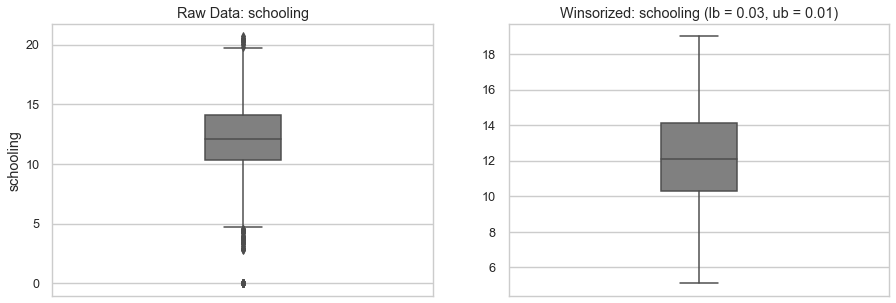

In [63]:
from scipy.stats.mstats import winsorize
def winsor_opt(data, lowerpc = 0, upperpc=0):
    winsorized_tmp = winsorize(data, (lowerpc, upperpc))
    ## Plot comparison between original and winsorized_tmp
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    f = sns.boxplot(y = data, color = 'grey')
    plt.title('Raw Data: {}'.format(data.name))
    f.set_xlim(-2,2)
    plt.subplot(1,2,2)
    f = sns.boxplot(y = winsorized_tmp, color = 'grey')
    plt.title('Winsorized: {} (lb = {}, ub = {})'.format(data.name, lowerpc, upperpc))
    f.set_xlim(-2,2)

# The function is applied for 'schooling' below, showing the empirical process of lower and upper bound selection for winsorization
winsor_opt(df['schooling'],0.03, 0.01)

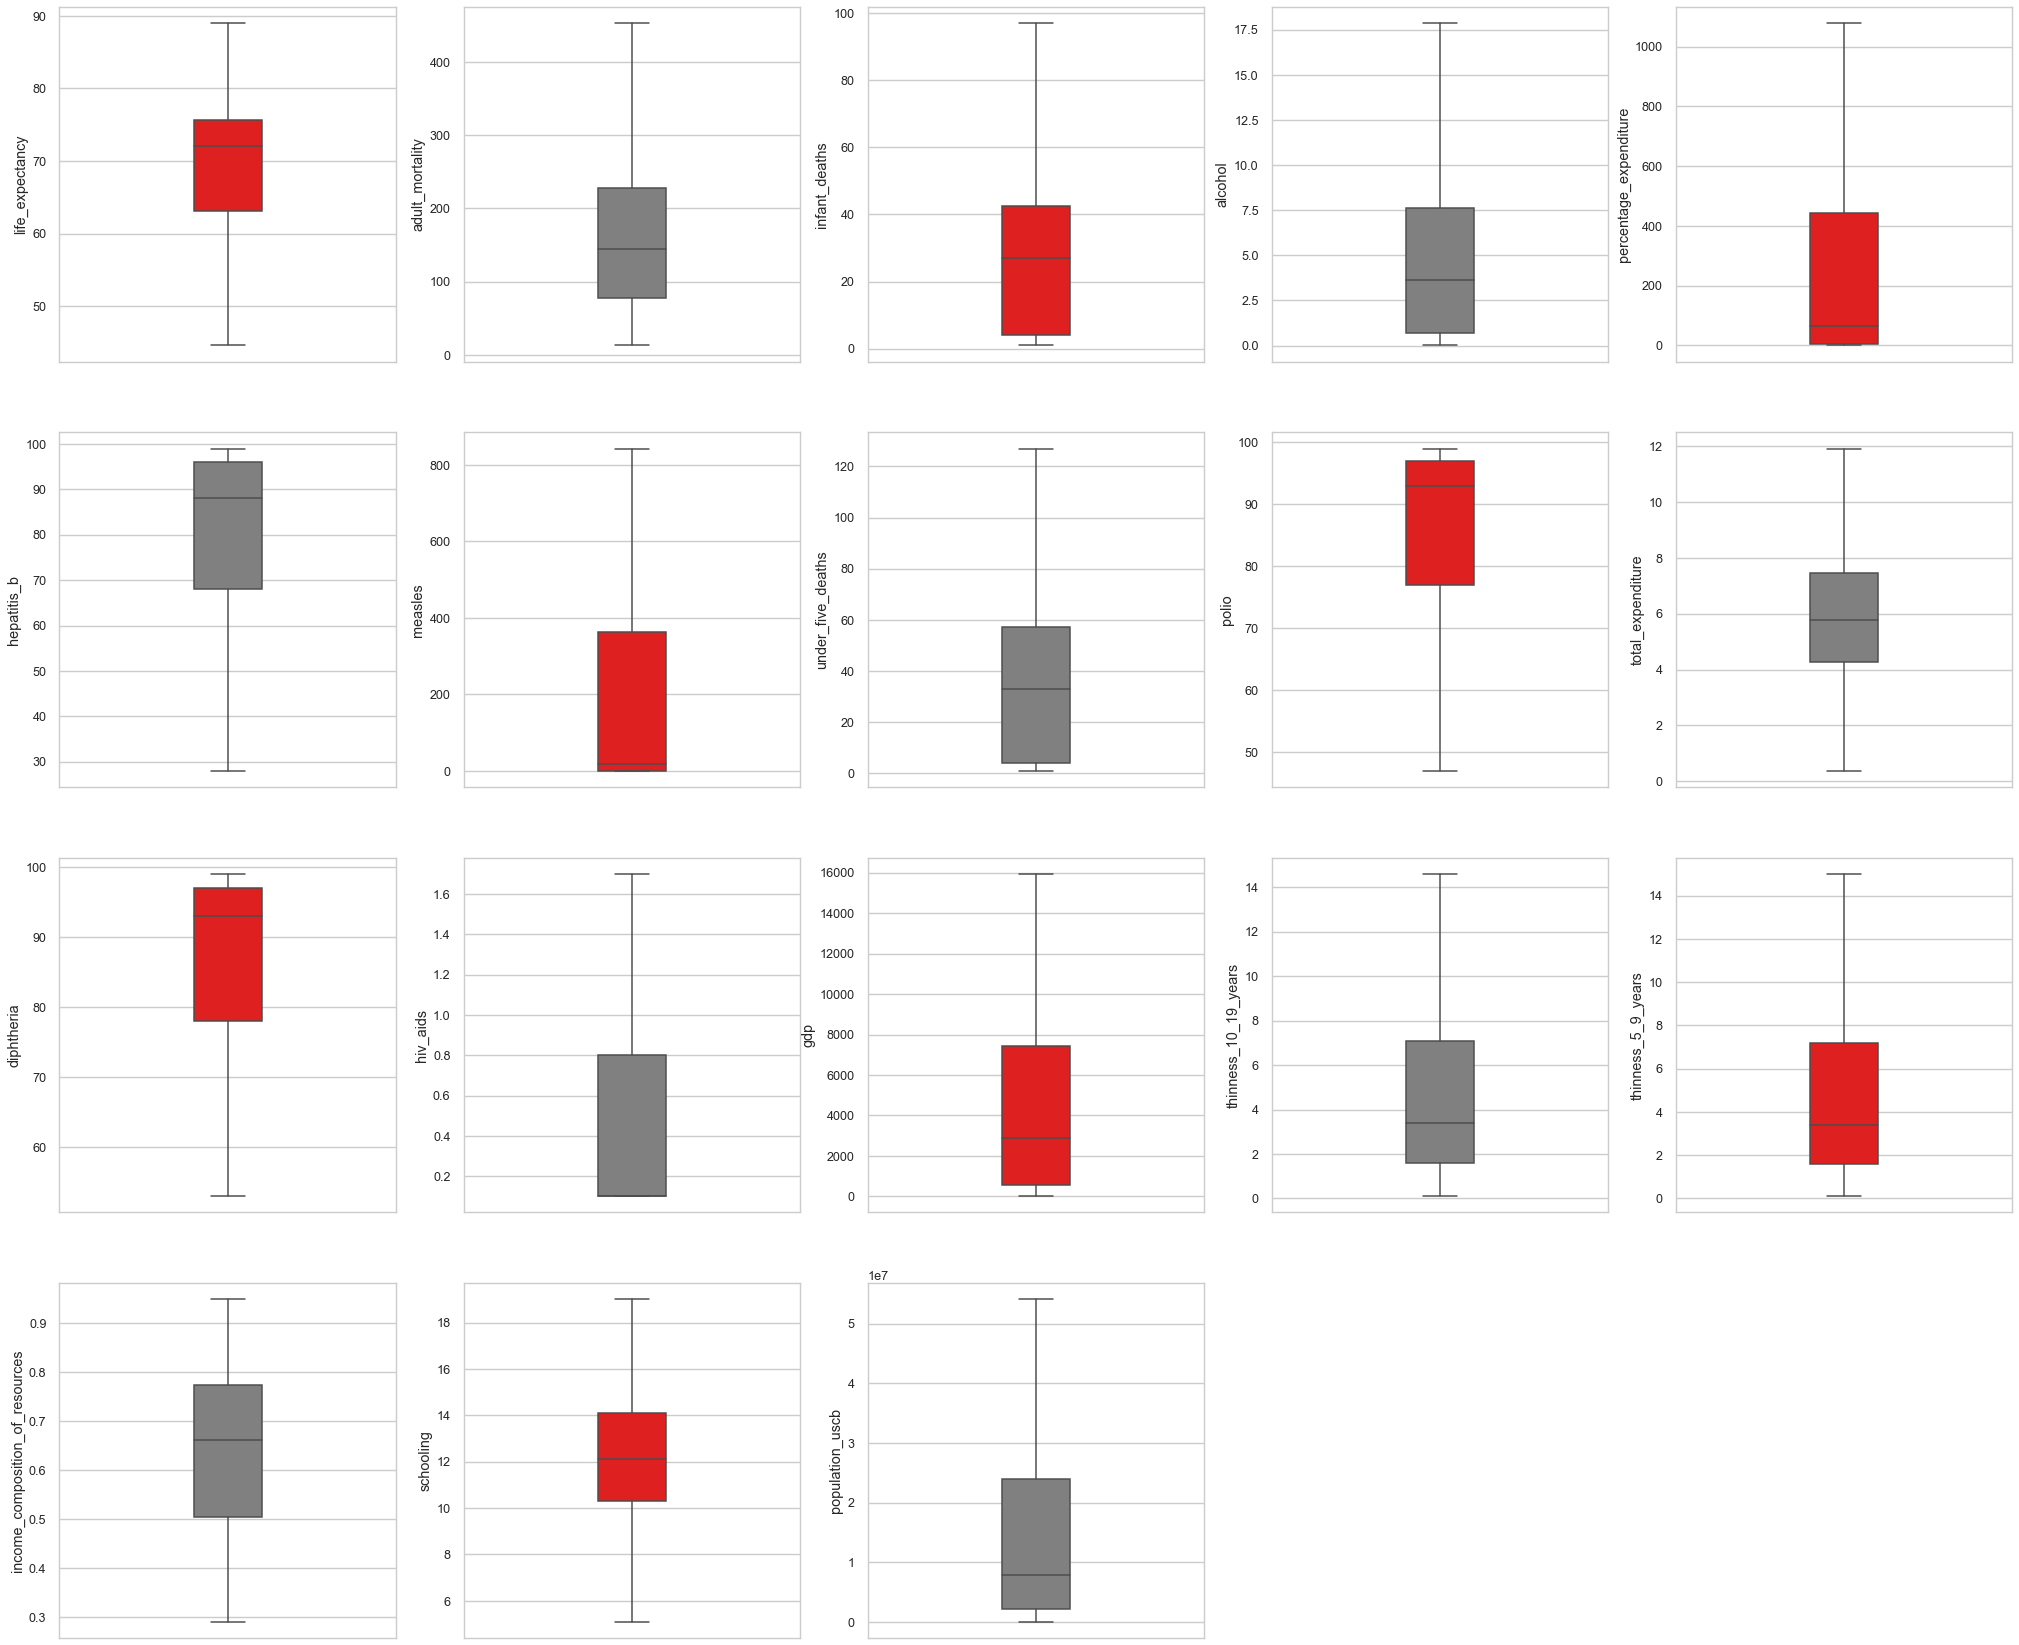

In [64]:
## Write another function for applying the optimal winsorization to each variable, creating a new winsorized dataframe 'df_wins' in the process
# First, write a quick dictionary with variables as keys and lb and up values as index
wins_opt_val = [[.005,0],
                [0,.03],
                [0,.048],
                [0,0],
                [0,0.135],
                [.11,0],
                [0,.19],
                [0,.055],
                [.09,0],
                [0,.015],
                [.11,0],
                [0,.19],
                [0,.11],
                [0,.04],
                [0,.04],
                [.05,0],
                [.03,.01],
                [0,.12]]
                
wins_dict = dict(zip(var_list,wins_opt_val))
# create a winsorized dataframe 'df_wins'
df_wins= df.iloc[:,0:3]
for ii in var_list:
    df_wins[ii] = winsorize(df[ii], (wins_dict[ii][0], wins_dict[ii][1]))

# Let's use the previous boxplotter function to check the winsorized data(frame)
fig2 = plt.figure(figsize=(35,30))
for ii,jj in enumerate(var_list):
    boxplotter(df_wins[jj], ii+1)

We will go ahead and re-run our Tukey's IQR function on the winsorized data. Demonstrates effective limiting of extreme outliers through winsorization.

In [65]:
for var in var_list:
    tukey_iqr(df_wins[var], 1.5)

Variable = life_expectancy: 
IQR outliers fraction = 0.0 %
****************************************
Variable = adult_mortality: 
IQR outliers fraction = 0.0 %
****************************************
Variable = infant_deaths: 
IQR outliers fraction = 0.0 %
****************************************
Variable = alcohol: 
IQR outliers fraction = 0.0 %
****************************************
Variable = percentage_expenditure: 
IQR outliers fraction = 0.0 %
****************************************
Variable = hepatitis_b: 
IQR outliers fraction = 0.0 %
****************************************
Variable = measles: 
IQR outliers fraction = 0.0 %
****************************************
Variable = under_five_deaths: 
IQR outliers fraction = 0.0 %
****************************************
Variable = polio: 
IQR outliers fraction = 0.0 %
****************************************
Variable = total_expenditure: 
IQR outliers fraction = 0.0 %
****************************************
Variable = diphtheria

***
## Data Exploration
***

### Univariate Analysis

This section will explore winsorized continuous variables as well as preliminary analysis of categorical variables. This will be achieved initially using Pandas's describe() function as well as evaluation of data distributions and counts etc. 

In [66]:
df_wins.describe(include = 'all')

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling,population_uscb
count,2928,2928.00000,2928,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,...,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2.928000e+03
unique,183,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Malta,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.50000,NaN,69.234836,165.704235,28.660795,4.529275,282.098414,77.769120,223.728825,...,84.894126,5.900523,85.427937,0.509631,4874.835807,4.687353,4.712210,0.640443,12.054524,1.590218e+07
std,NaN,4.61056,NaN,9.495792,112.383150,25.926537,4.058037,384.583029,23.397575,333.733740,...,16.485597,2.390789,15.144750,0.641495,5167.257432,3.856629,3.914324,0.171417,3.058507,1.818591e+07
min,NaN,2000.00000,NaN,44.600000,13.000000,1.000000,0.010000,0.000000,28.000000,0.000000,...,47.000000,0.370000,53.000000,0.100000,1.681350,0.100000,0.100000,0.291000,5.100000,2.727400e+04
25%,NaN,2003.75000,NaN,63.100000,78.000000,4.000000,0.680000,4.853964,68.000000,0.000000,...,77.000000,4.260000,78.000000,0.100000,562.496915,1.600000,1.600000,0.504000,10.300000,2.110506e+06
50%,NaN,2007.50000,NaN,72.100000,144.000000,27.000000,3.650000,65.611455,88.000000,17.000000,...,93.000000,5.780000,93.000000,0.100000,2861.854668,3.400000,3.400000,0.662000,12.100000,7.804164e+06
75%,NaN,2011.25000,NaN,75.700000,228.000000,42.460658,7.600000,442.614322,96.000000,362.250000,...,97.000000,7.470000,97.000000,0.800000,7413.645004,7.100000,7.200000,0.773000,14.100000,2.390101e+07


***
#### Continuous variables
***

We've seen the (winsorized) box plots in the previous section, but let's look at the distributions and check their closeness to normality using the Jarque-Bera normality test

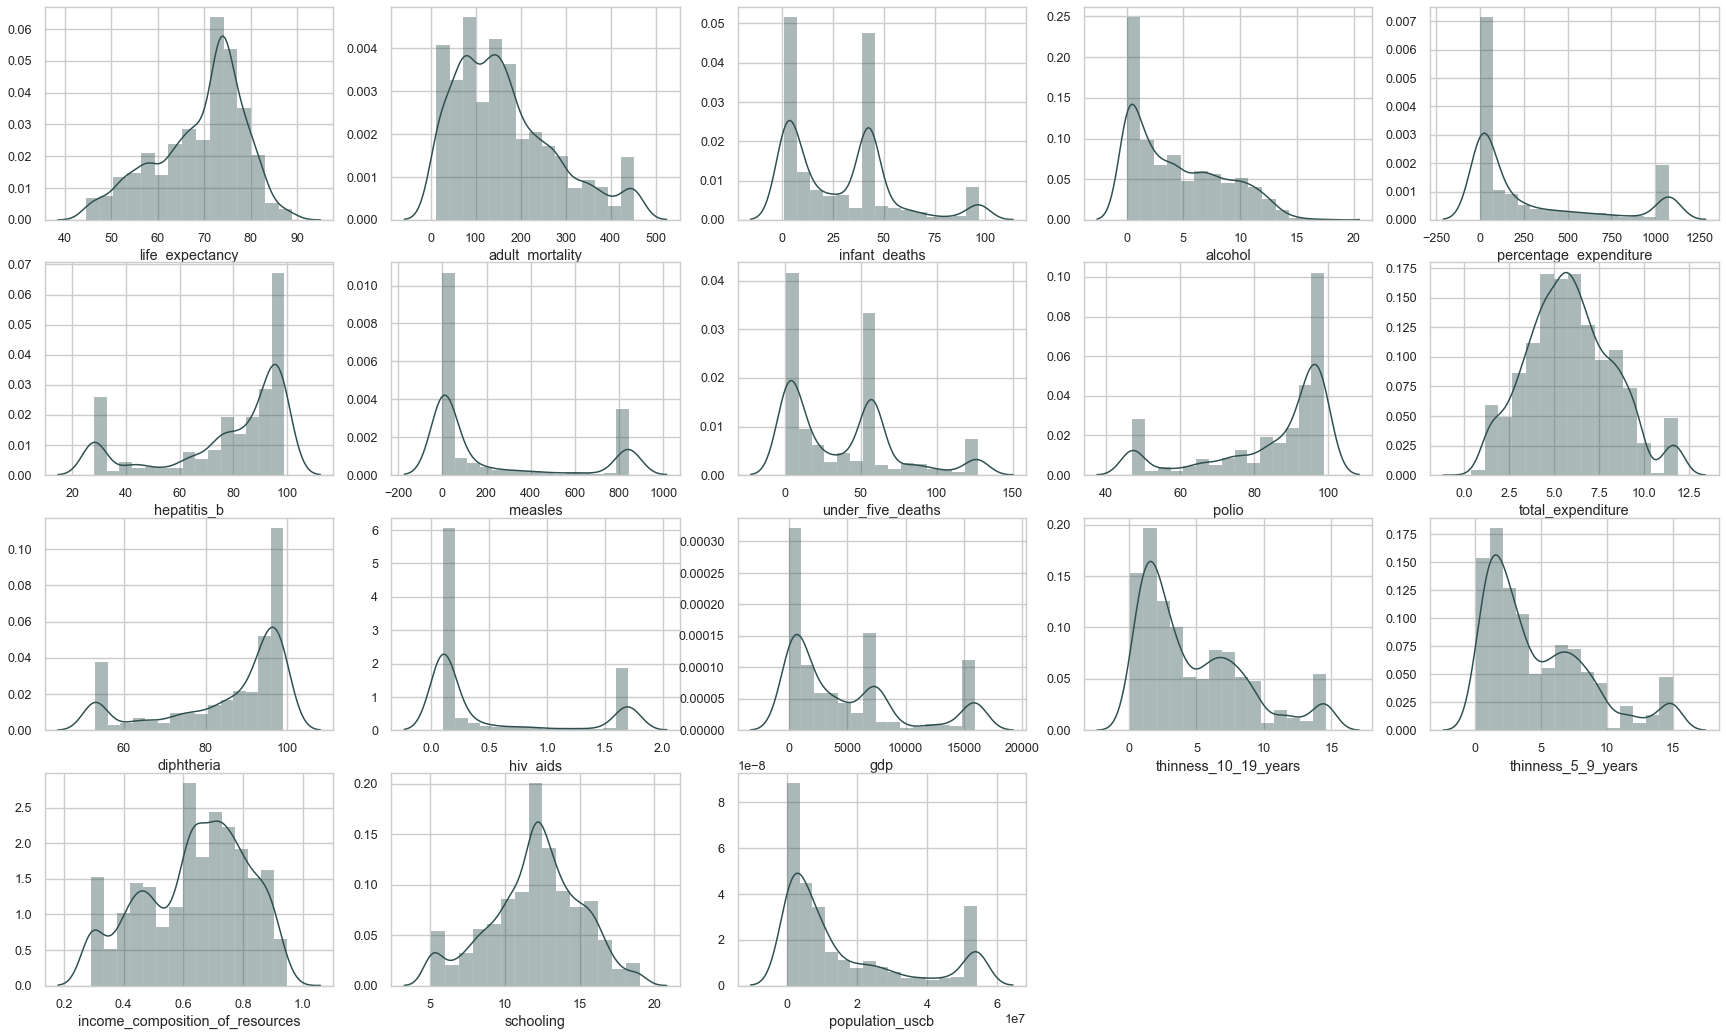

In [67]:
fig = plt.figure(figsize=(30,18))
for ii,jj in enumerate(var_list):
    histoplot(df_wins[jj], ii+1)

Let's compare Jarque-Bera normality assessments for the original data and for the winsorized data. Jarque-Bera works for larger numbers of data samples (>2000)

In [68]:
from scipy import stats
for ii in var_list:
    print('Variable: {}'.format(ii))
    print('Jarque-Bera (Raw data)\t\ttest-statistic, p-value): {}'.format(stats.jarque_bera(df[ii])))
    print('Jarque-Bera (Winsorized data)\ttest-statistic, p-value): {}'.format(stats.jarque_bera(df_wins[ii])))
    print(100*'-')

Variable: life_expectancy
Jarque-Bera (Raw data)		test-statistic, p-value): (205.61247743959427, 0.0)
Jarque-Bera (Winsorized data)	test-statistic, p-value): (199.45738810168038, 0.0)
----------------------------------------------------------------------------------------------------
Variable: adult_mortality
Jarque-Bera (Raw data)		test-statistic, p-value): (1230.8185748346884, 0.0)
Jarque-Bera (Winsorized data)	test-statistic, p-value): (333.89998626554177, 0.0)
----------------------------------------------------------------------------------------------------
Variable: infant_deaths
Jarque-Bera (Raw data)		test-statistic, p-value): (1740287.9922685318, 0.0)
Jarque-Bera (Winsorized data)	test-statistic, p-value): (396.5077133939525, 0.0)
----------------------------------------------------------------------------------------------------
Variable: alcohol
Jarque-Bera (Raw data)		test-statistic, p-value): (252.88055665872756, 0.0)
Jarque-Bera (Winsorized data)	test-statistic, p-value)

Winsorization improved the test statistic to a large degree for most variables. However, for all variables, the p-value is so close to zero (P<<<<.05) that we cannot conclude that any of the sample distributions are drawn from a normal distribution.

***
#### Categorical variables
***

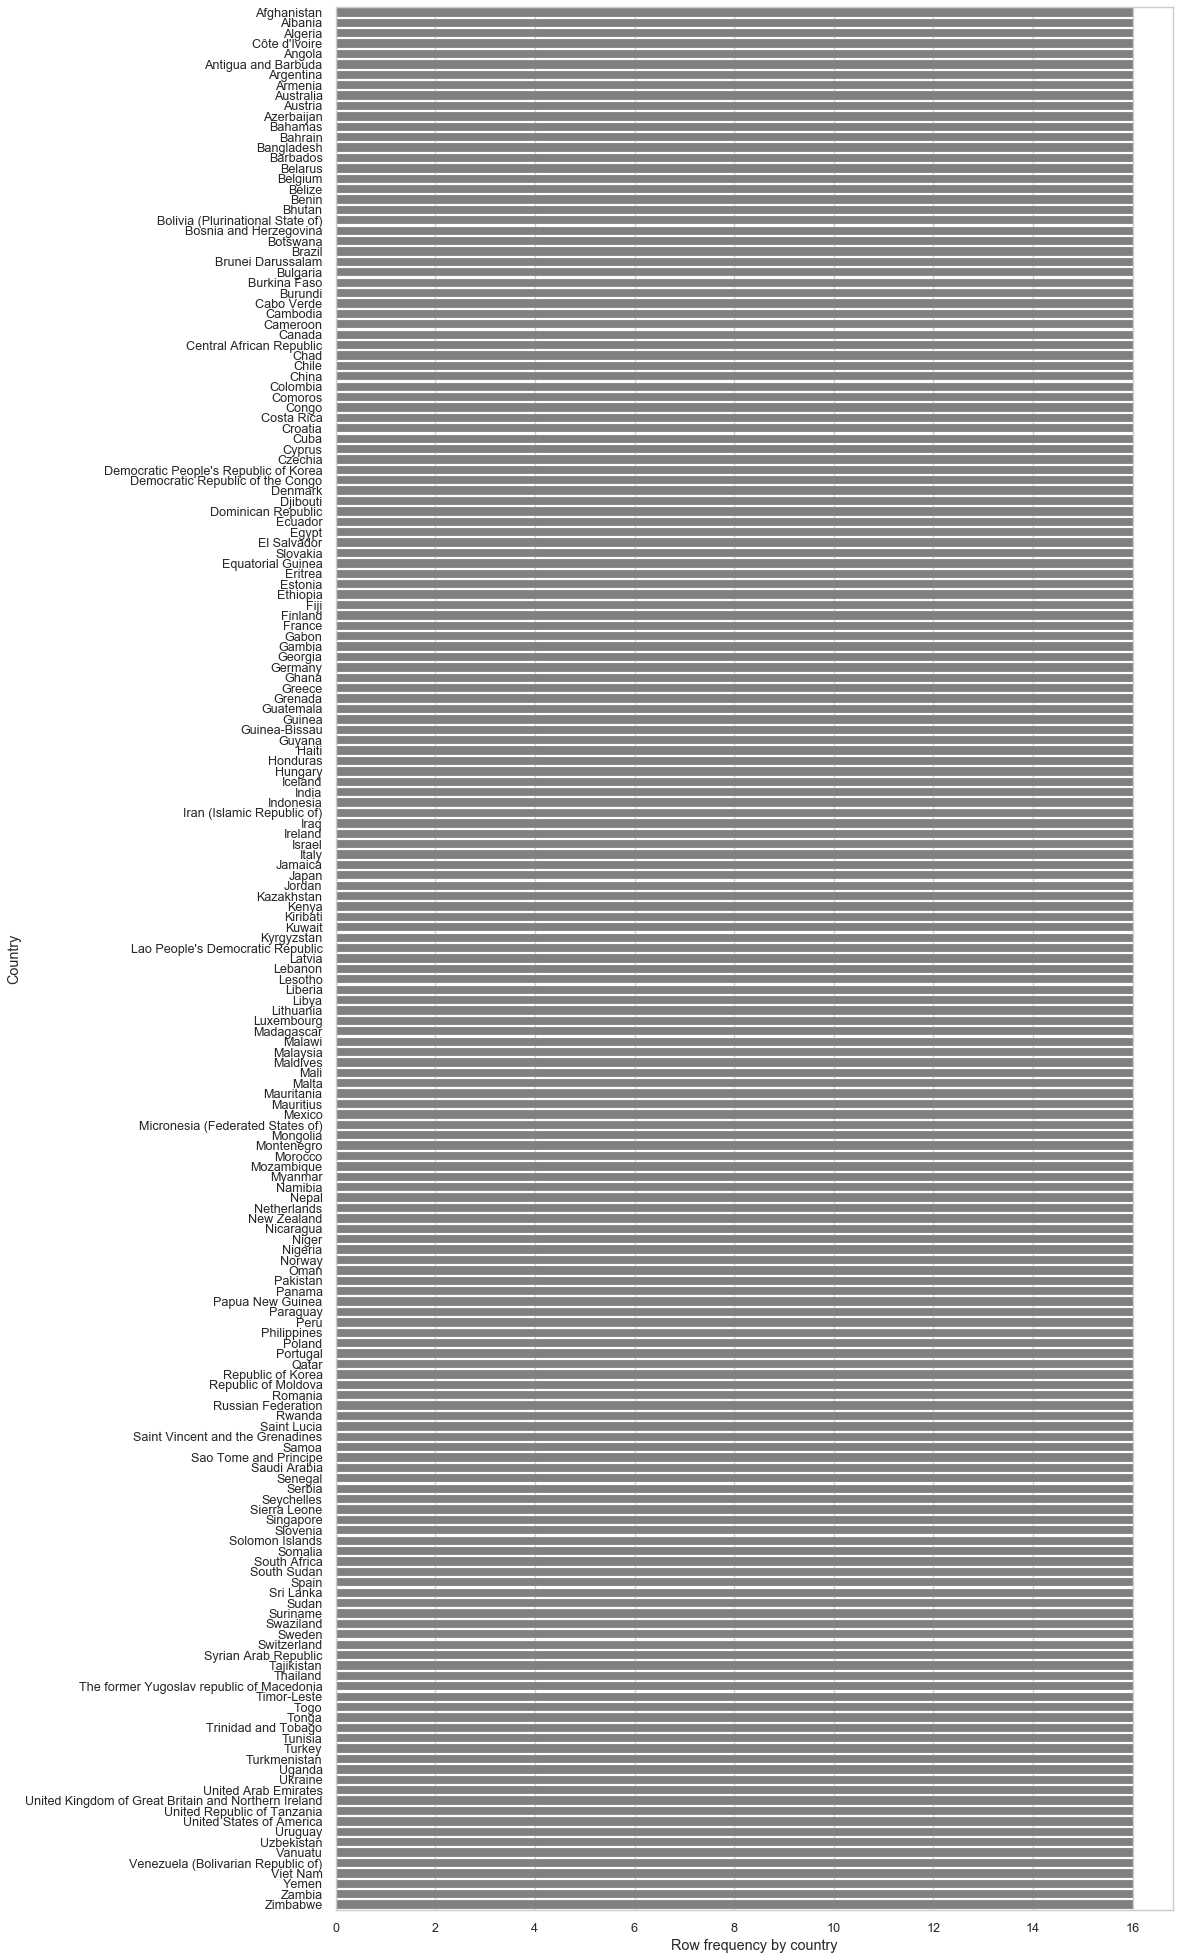

In [69]:
fig = plt.figure(figsize = (15,35))
sns.barplot(y = df_wins['country'].unique(), x = df_wins['country'].value_counts(), color = 'grey')
plt.xlabel('Row frequency by country');
plt.ylabel('Country');

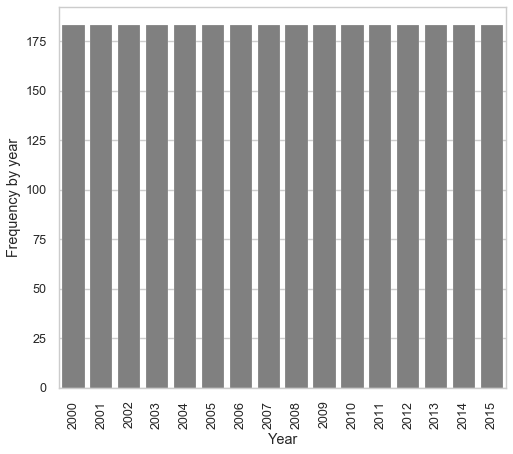

In [70]:
df_wins['year'].value_counts()
sns.barplot(x = df_wins['year'].unique(), y = df_wins['year'].value_counts(), color = 'grey')
plt.xticks(rotation = 'vertical');
plt.xlabel('Year');
plt.ylabel('Frequency by year');

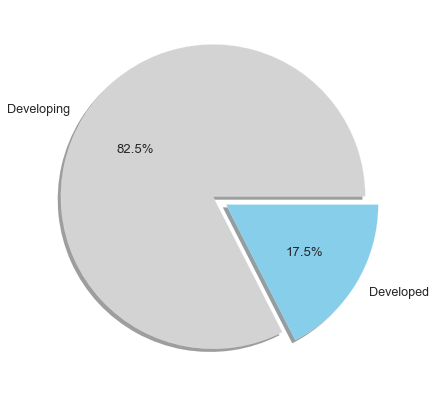

In [71]:
# create data for pie chart. Want to display 'status' i.e. fraction of developed versus developing
names= list(df_wins['status'].unique())
counts = list(df_wins['status'].value_counts())
explode = (0, 0.1) 

plt.pie(counts, labels=names, explode = explode, shadow=True, colors=['lightgrey','skyblue'], autopct='%1.1f%%')
plt.show()

For the **categorical variables**, we can conclude that (a) each country is represented by 16 rows, (b) each year 2000-2015 is represented by 183 countries, and the majority (82.5 %) of our countries fall under the 'developing' **status** category. Moving on to multivariate analysis.......

### Multivariate Analysis

Let's start with continuous-continuous (bivariate) analysis. This will involve use of the Pandas .corr() function as well as visual representation of relationships of continuous variables with life-expectancy as well as with all others through Seaborn's heatmap. Then we can move on to examine the relationship between the categorical variables (i.e. status, year) and target variable (life_expectancy).

***
#### Continuous-continuous bivariate analysis
***

In [72]:
## corr() method but drop year. We can use the variable list 'var_list' from earlier
df_wins[var_list].corr()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling,population_uscb
life_expectancy,1.000000,-0.701909,-0.217629,0.400730,0.488842,0.332044,-0.337252,-0.288776,0.563843,0.233894,0.583290,-0.797192,0.513711,-0.521997,-0.517481,0.791261,0.743320,0.028088
adult_mortality,-0.701909,1.000000,0.122247,-0.201338,-0.318925,-0.208421,0.218501,0.168393,-0.355566,-0.140488,-0.370446,0.612715,-0.327156,0.352966,0.356800,-0.525264,-0.469011,-0.002267
infant_deaths,-0.217629,0.122247,1.000000,-0.054885,-0.096925,-0.155992,0.329961,0.966803,-0.211038,-0.074055,-0.223456,0.123631,-0.058458,0.196405,0.202889,-0.166061,-0.182952,0.276275
alcohol,0.400730,-0.201338,-0.054885,1.000000,0.387539,0.094268,-0.195580,-0.099912,0.267802,0.304167,0.280547,-0.204388,0.411757,-0.449682,-0.439780,0.483618,0.527184,0.020459
percentage_expenditure,0.488842,-0.318925,-0.096925,0.387539,1.000000,0.102882,-0.195965,-0.125011,0.264603,0.174527,0.273088,-0.299683,0.725244,-0.335103,-0.336717,0.558669,0.535255,-0.063363
hepatitis_b,0.332044,-0.208421,-0.155992,0.094268,0.102882,1.000000,-0.242187,-0.187746,0.581083,0.110676,0.647039,-0.318364,0.133140,-0.153718,-0.162233,0.299920,0.298347,-0.062543
measles,-0.337252,0.218501,0.329961,-0.195580,-0.195965,-0.242187,1.000000,0.357468,-0.306349,-0.156970,-0.307506,0.225589,-0.187155,0.357776,0.362731,-0.272324,-0.330198,0.470007
under_five_deaths,-0.288776,0.168393,0.966803,-0.099912,-0.125011,-0.187746,0.357468,1.000000,-0.266978,-0.074416,-0.280992,0.193819,-0.095500,0.226386,0.228985,-0.234802,-0.249022,0.253106
polio,0.563843,-0.355566,-0.211038,0.267802,0.264603,0.581083,-0.306349,-0.266978,1.000000,0.176888,0.848486,-0.467247,0.319401,-0.283075,-0.280563,0.510306,0.508606,-0.024034
total_expenditure,0.233894,-0.140488,-0.074055,0.304167,0.174527,0.110676,-0.156970,-0.074416,0.176888,1.000000,0.187525,-0.120600,0.146233,-0.294576,-0.304546,0.193531,0.276572,-0.049957


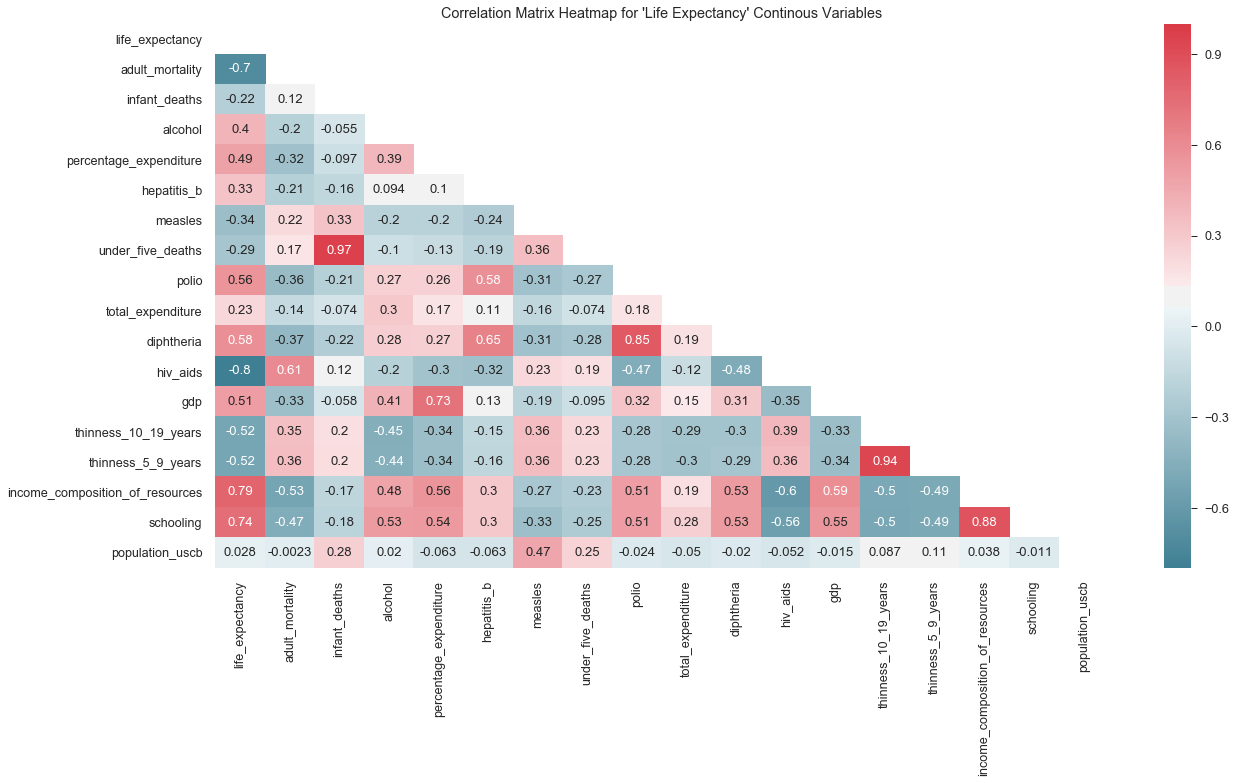

In [73]:
# Easier to visualize with Seaborn's heatmap
# Let's plot just half the matrix for clarity. use numpy's triu (upper triangle method) to create mask
maskmap = np.triu(df_wins[var_list].corr())
corrmat = df_wins[var_list].corr() # create correlation matrix as corrmat
fig = plt.figure(figsize=(20,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corrmat, annot = True, cmap=cmap, mask = maskmap)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.title("Correlation Matrix Heatmap for 'Life Expectancy' Continous Variables");

***
**Noteworthy Observations**</br>
***
**life_expectancy** shows moderately strong positive correlations with **income_composition_of_resources (r = 0.79)** as well as **schooling (r = 0.74)**</br>

**life_expectancy** shows moderatiely strong negative correlations with **hiv_aids (r = -0.8)** as well as **adult_mortality (r = -0.7)**</br>

**life_expectancy** shows reasonably strong positive (r > 0.5) and negative (r < -0.5) correlations with several other variables, but NOT **population_ucsb (r = 0.028)**</br>

**infant_deaths** and **under_five_deaths** are strongly (positively = 0.97) correlated</br>

**percentage_expenditure** and **gdp** are strongly (positively: r = 0.73) correlated</br>

**heptitis_b** variable shows reasonably strong positive correlations with **polio (r = 0.58)** and **diptheria (r = 0.65)**</br>

**polio** and **diptheria**  variables are strongly correlated (r = 0.85)</br>

**thinness** variables (1-to-5 and 10-to-19) strongly correlated (r = 0.94)</br>

**income_composition_of_resoucrces** and **schooling** show strong positive correlations (r = 0.88)</br>

As might be expected, **hiv_aids** and **income_composition_of_resources** (which is a Human Development index) show a reasonably strong negative correlation (r = -0.6)</br>


***
#### Categorical-continuous bivariate analysis
***

Let's start with 'status' (developed/developing) with respect to our continuous variables (var_list).</br>
First, let's visualize using simple bar plots

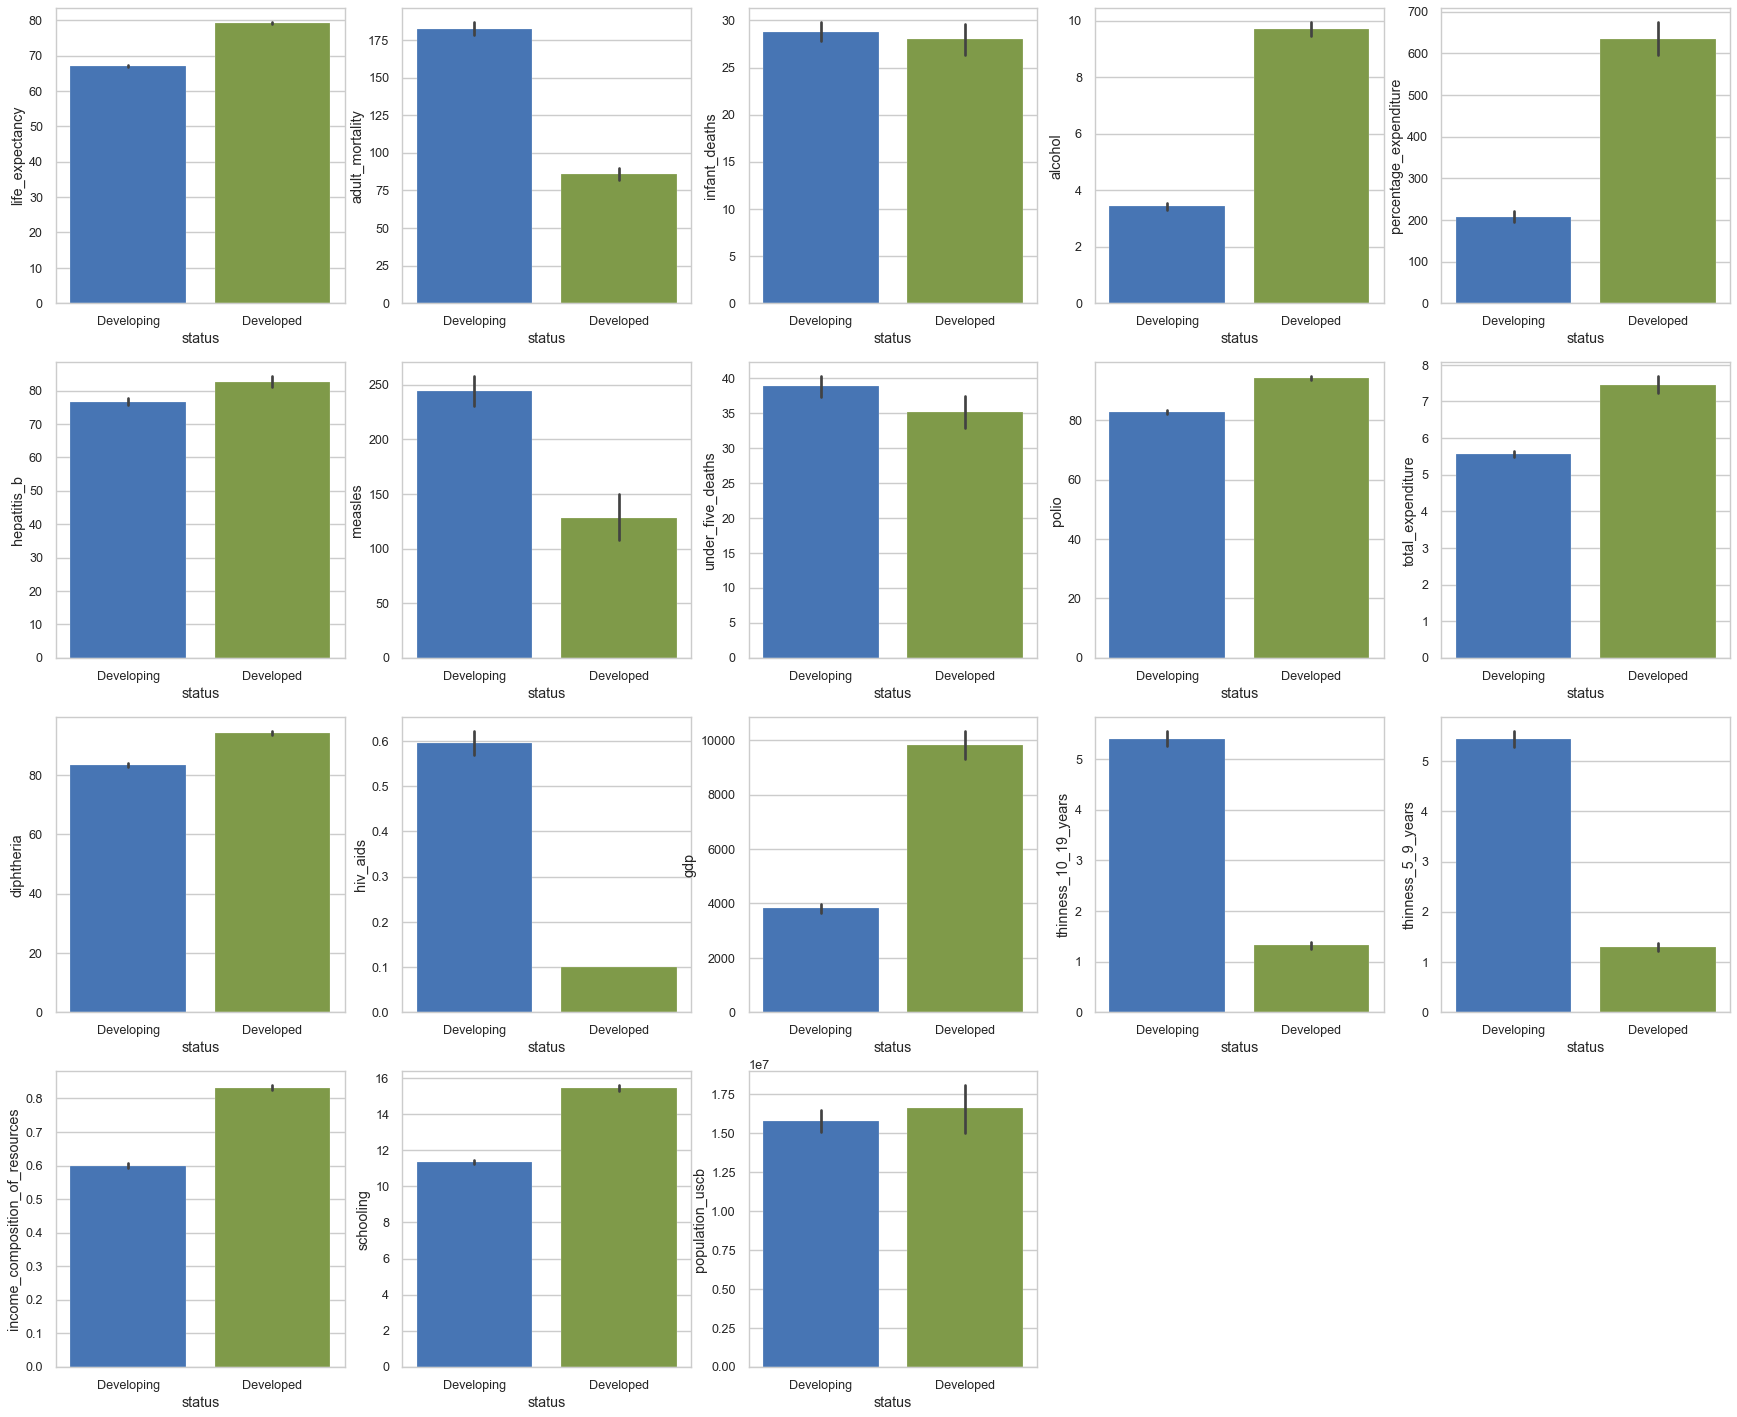

In [74]:
def barplotter(xdata, ydata, dataframe, panel):
    plt.subplot(4,5,panel)
    sns.barplot(x = xdata, y = ydata, data = dataframe)

fig = plt.figure(figsize=(30,25))
for ii,jj in enumerate(var_list):
    barplotter('status', jj, df_wins, ii+1)

Some of these look very different, and we should run t-tests for each variable to test the significance.

In [75]:
from scipy import stats
for ii in var_list:
    print('Variable: {}, (Developed v Developing t-test for independent samples)'.format(ii))
    print(stats.ttest_ind(df_wins[df_wins['status']=='Developed'][ii], df_wins[df_wins['status']=='Developing'][ii], equal_var=False))
    print('*'*100)

Variable: life_expectancy, (Developed v Developing t-test for independent samples)
Ttest_indResult(statistic=47.91373059474778, pvalue=2e-323)
****************************************************************************************************
Variable: adult_mortality, (Developed v Developing t-test for independent samples)
Ttest_indResult(statistic=-32.19706036339943, pvalue=6.774191107921091e-187)
****************************************************************************************************
Variable: infant_deaths, (Developed v Developing t-test for independent samples)
Ttest_indResult(statistic=-0.7529459318315219, pvalue=0.45165899704706647)
****************************************************************************************************
Variable: alcohol, (Developed v Developing t-test for independent samples)
Ttest_indResult(statistic=42.75405040576709, pvalue=2.3661441488983354e-210)
**************************************************************************************

Hence, country status (developed v developing) appears to be highly correlated with most continuous variables, infant_deaths aside. Notably, country status is highly correlated with life expectancy. Whilst we are at it, what are the statistics for status and life_expectancy? Groupby 'status', shows a mean higher life_expectancy of 12 years for developed countries. Note also the much larger representation (count) for developing countries (2416 vs 512 rows)

In [76]:
df_wins.groupby('status')['life_expectancy'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Developed,512.0,79.197852,3.930942,69.9,76.8,79.25,81.7,89.0
Developing,2416.0,67.123469,8.972916,44.6,61.1,69.00,74.0,89.0


Finally, how does life_expectancy change with the year variable?

Text(0.5, 1.0, "Pearson's r = 0.17")

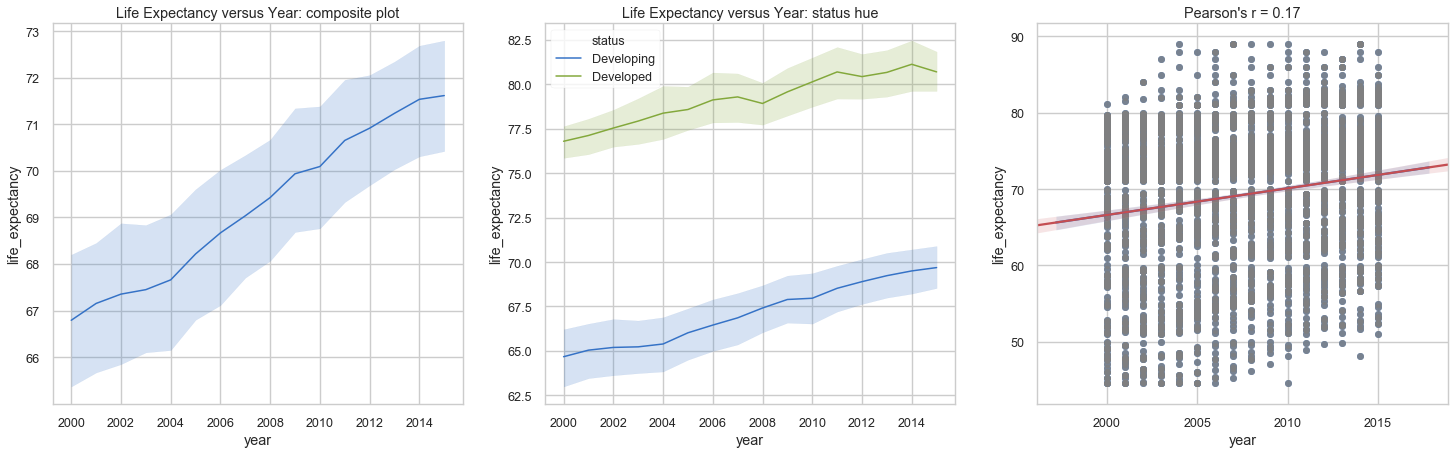

In [77]:
fig = plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
sns.lineplot(x = 'year', y = 'life_expectancy', data = df_wins)
plt.title('Life Expectancy versus Year: composite plot')
plt.subplot(1,3,2)
sns.lineplot(x = 'year', y = 'life_expectancy', data = df_wins, hue = 'status')
plt.title('Life Expectancy versus Year: status hue')
plt.subplot(1,3,3)
sns.regplot(x = 'year', y = 'life_expectancy', data = df_wins)

t = sns.regplot(x = 'year', y = 'life_expectancy', data = df_wins, fit_reg=False, color = 'grey')
t = sns.regplot(x = 'year', y = 'life_expectancy', data = df_wins, scatter=False, color = 'r')
t.axes.set_title("Pearson's r = {}".format(np.round(df_wins['year'].corr(df_wins['life_expectancy']),decimals=3)))

Interesting, as a whole there appears to be a steady relationship between average life_expectancy and year, with an increase of approximately five years over a 15 year timespan. However, the mean increase is approximately 3 years when considering status (subplot 2). The relationship between life_expectancy and year is displayed in subplot 3, suggesting a weak positive correlation (r = 0.17). If year is to be a useful feature, then we might want to investigate the changes in life expectancy between years (or rate of increase). Are the between year-changes significant for the 'lumped' status data? If not, then they definitely will not be on a developed and developing 'status' level. Run a t-test.

In [78]:
df_wins[df_wins['year']==2000]['life_expectancy'].mean()

66.79344262295085

In [79]:
years = df_wins['year'].unique()
years.sort()
for year in years[:-1]:
    print('Years: {} and {}'.format(year, year+1))
    print(stats.ttest_ind(df_wins[df_wins['year']==year]['life_expectancy'],
                          df_wins[df_wins['year']==year+1]['life_expectancy']))
    print('-'*80)

Years: 2000 and 2001
Ttest_indResult(statistic=-0.3400525344344233, pvalue=0.7340131091358817)
--------------------------------------------------------------------------------
Years: 2001 and 2002
Ttest_indResult(statistic=-0.1895715255399406, pvalue=0.8497505661351722)
--------------------------------------------------------------------------------
Years: 2002 and 2003
Ttest_indResult(statistic=-0.09135597645375902, pvalue=0.9272599941602606)
--------------------------------------------------------------------------------
Years: 2003 and 2004
Ttest_indResult(statistic=-0.19895234398359365, pvalue=0.842411103676195)
--------------------------------------------------------------------------------
Years: 2004 and 2005
Ttest_indResult(statistic=-0.535455637194685, pvalue=0.5926618156608099)
--------------------------------------------------------------------------------
Years: 2005 and 2006
Ttest_indResult(statistic=-0.4418243119861577, pvalue=0.6588787098622291)
-------------------------

i.e. no significance detected between years. Therefore highly probable that even less significance will be detected on the developed versus developing country status level. Out of the categorical variables, 'status' should be explored in the Feature Engineering section.

***
## Feature Engineering
***

* It's probably best to create a 'feature_engineering' dataframe (df_fe), conserving both the original raw data (df) and cleaned, winsorized (df_wins) versions
* At this stage we should drop any columns that we have deemed unrelated to the target variable, 'life_expectancy'. These include year and country (193 different countries with 16 observations each).
* We should also convert relevant categorical values to numeric type. Here, we can use one-hot encoding to convert our 'status' variable.
* Reanalysis of correlation plots and heatmaps will allow us to evaluate which variables are highly correlated with the target variable 'life_expectancy'
* If two variables are also highly correlated, we should drop one to reduce dimensionality, and we'll keep the feature that shows larger correlation with target variable
* If we run PCA, we should also drop the target variable prior to its execution

In [80]:
# Create df_fe dataframe, drop 'country' and 'year'
df_fe = df_wins
df_fe = df_fe.drop(columns = ['country', 'year'])


In [81]:
df_fe

,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,thinness_10_19_years,thinness_5_9_years,income_composition_of_resources,schooling,population_uscb
0,Developing,65.0,263.0,62.0,0.01,71.279624,65.0,843,83.0,47.0,8.16,65.0,0.1,584.259210,14.6,15.0,0.479,10.1,32564342.0
1,Developing,59.9,271.0,64.0,0.01,73.523582,62.0,492,86.0,58.0,8.18,62.0,0.1,612.696514,14.6,15.0,0.476,10.0,31822848.0
2,Developing,59.9,268.0,66.0,0.01,73.219243,64.0,430,89.0,62.0,8.13,64.0,0.1,631.744976,14.6,15.0,0.470,9.9,31108077.0
3,Developing,59.5,272.0,69.0,0.01,78.184215,67.0,843,93.0,67.0,8.52,67.0,0.1,669.959000,14.6,15.0,0.463,9.8,30419928.0
4,Developing,59.2,275.0,71.0,0.01,7.097109,68.0,843,97.0,68.0,7.87,68.0,0.1,63.537231,14.6,15.0,0.454,9.5,29757566.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Developing,44.6,453.0,27.0,4.36,0.000000,68.0,31,42.0,67.0,7.13,65.0,1.7,454.366654,9.4,9.4,0.407,9.2,12277825.0
2934,Developing,44.6,453.0,26.0,4.06,0.000000,28.0,843,41.0,47.0,6.52,68.0,1.7,453.351155,9.8,9.9,0.418,9.5,12259894.0
2935,Developing,44.8,73.0,25.0,4.43,0.000000,73.0,304,40.0,73.0,6.53,71.0,1.7,57.348340,1.2,1.3,0.427,10.0,12223057.0
2936,Developing,45.3,453.0,25.0,1.72,0.000000,76.0,529,39.0,76.0,6.16,75.0,1.7,548.587312,1.6,1.7,0.427,9.8,12150636.0


In [82]:
# one- hot encoding for 'status'
df_fe = pd.concat([df_fe, pd.get_dummies(df_fe['status'], drop_first=True)], axis = 1)
df_fe.drop(columns = ['status'], inplace=True)

In [83]:
# How correlated are our variables with the one hot encoded 'developed' column?
var_list = df_fe.columns[:-1]
for ii in var_list:
    r = np.corrcoef(df_fe[ii], df_fe[df_fe.columns[-1]])
    print('Correlation (Pearson): {} versus {} = {}'.format(ii, df_fe.columns[-1], r[0][1]))

Correlation (Pearson): life_expectancy versus Developing = -0.48308139983465276
Correlation (Pearson): adult_mortality versus Developing = 0.3268314484971123
Correlation (Pearson): infant_deaths versus Developing = 0.011131097609267069
Correlation (Pearson): alcohol versus Developing = -0.5888669055387635
Correlation (Pearson): percentage_expenditure versus Developing = -0.4206614706199659
Correlation (Pearson): hepatitis_b versus Developing = -0.09650342524737528
Correlation (Pearson): measles versus Developing = 0.13219368474351817
Correlation (Pearson): under_five_deaths versus Developing = 0.03788051887688322
Correlation (Pearson): polio versus Developing = -0.2614642331952574
Correlation (Pearson): total_expenditure versus Developing = -0.2996151118764357
Correlation (Pearson): diphtheria versus Developing = -0.27081880463709906
Correlation (Pearson): hiv_aids versus Developing = 0.2940086493749183
Correlation (Pearson): gdp versus Developing = -0.44021410048247345
Correlation (Pe

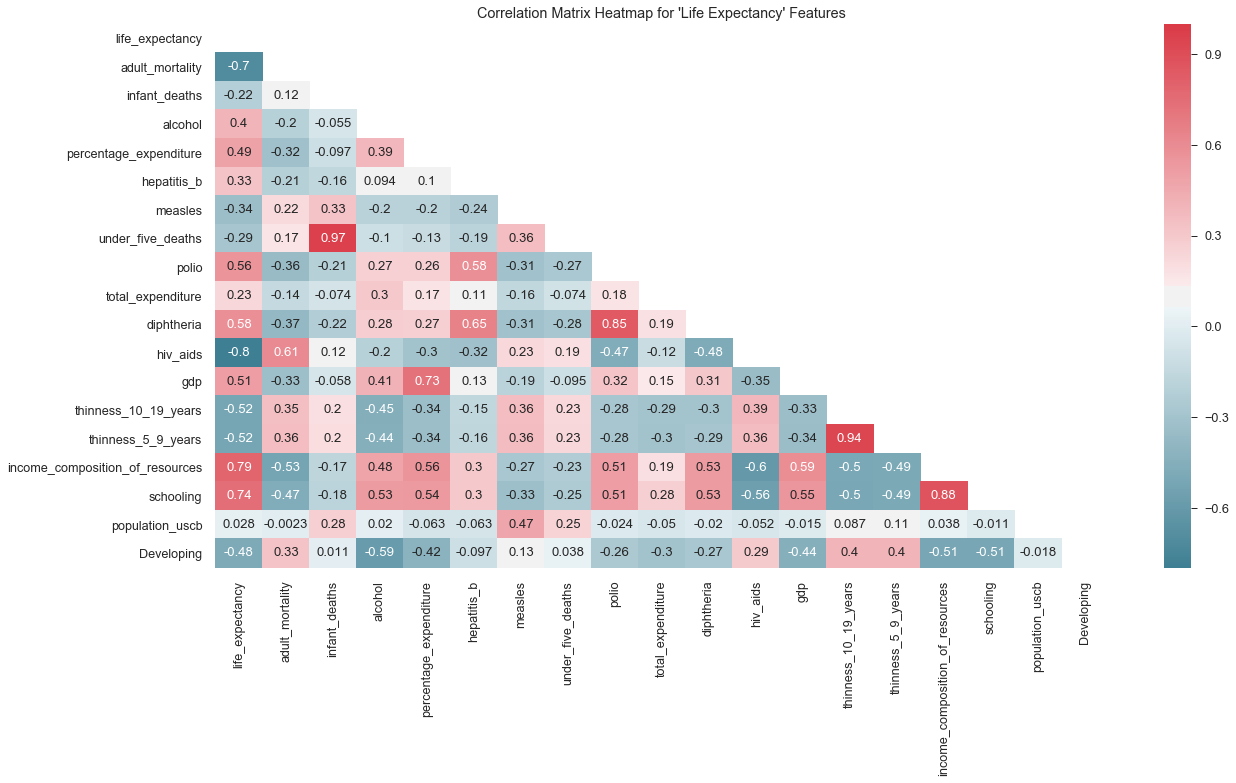

In [84]:
# We are going to be visualizing heatmaps as we drop variables etc, so a function would probably be better here
def heatmap_plotter(data):
    maskmap = np.triu(data.corr())
    corrmat = data.corr() # create correlation matrix as corrmat
    fig = plt.figure(figsize=(20,10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corrmat, annot = True, cmap=cmap, mask = maskmap)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom+0.5, top-0.5)
    plt.title("Correlation Matrix Heatmap for 'Life Expectancy' Features");
    
heatmap_plotter(df_fe)

Based on the above heatmap, we can go through some of the highly-correlated variables, and delete the variable that is less correlated with 'life_expectancy'</br>

For example (setting r threshold to >0.7 and <-0.7):</br>

* infant_deaths and under_five_deaths: r = 0.97 DROP infant_deaths</br>

* polio and diptheria: r = 0.85 DROP polio</br>

* percentage_expenditure and gdp: r = 0.97 DROP percentage_expenditure</br>

* thinness variables: r = 0.94 DROP thinness_10_19_years</br>

* schooling and income_composition_of_resources: r = 0.88 DROP schooling</br>

* In addition, we should go ahead and drop 'population_uscb' as it shows low correlation with other variables and life_expectancy</br>






In [85]:
df_fe_master = df_fe.drop(columns = ['infant_deaths', 'polio', 'percentage_expenditure', 'thinness_10_19_years', 'schooling', 'population_uscb'])
df_fe_master

,life_expectancy,adult_mortality,alcohol,hepatitis_b,measles,under_five_deaths,total_expenditure,diphtheria,hiv_aids,gdp,thinness_5_9_years,income_composition_of_resources,Developing
0,65.0,263.0,0.01,65.0,843,83.0,8.16,65.0,0.1,584.259210,15.0,0.479,1
1,59.9,271.0,0.01,62.0,492,86.0,8.18,62.0,0.1,612.696514,15.0,0.476,1
2,59.9,268.0,0.01,64.0,430,89.0,8.13,64.0,0.1,631.744976,15.0,0.470,1
3,59.5,272.0,0.01,67.0,843,93.0,8.52,67.0,0.1,669.959000,15.0,0.463,1
4,59.2,275.0,0.01,68.0,843,97.0,7.87,68.0,0.1,63.537231,15.0,0.454,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,44.6,453.0,4.36,68.0,31,42.0,7.13,65.0,1.7,454.366654,9.4,0.407,1
2934,44.6,453.0,4.06,28.0,843,41.0,6.52,68.0,1.7,453.351155,9.9,0.418,1
2935,44.8,73.0,4.43,73.0,304,40.0,6.53,71.0,1.7,57.348340,1.3,0.427,1
2936,45.3,453.0,1.72,76.0,529,39.0,6.16,75.0,1.7,548.587312,1.7,0.427,1


So we have gone from a starting 22 variables down to 13 using this approach. We can submit this to a PCA. But how does our new set of variables look with the heatmap?

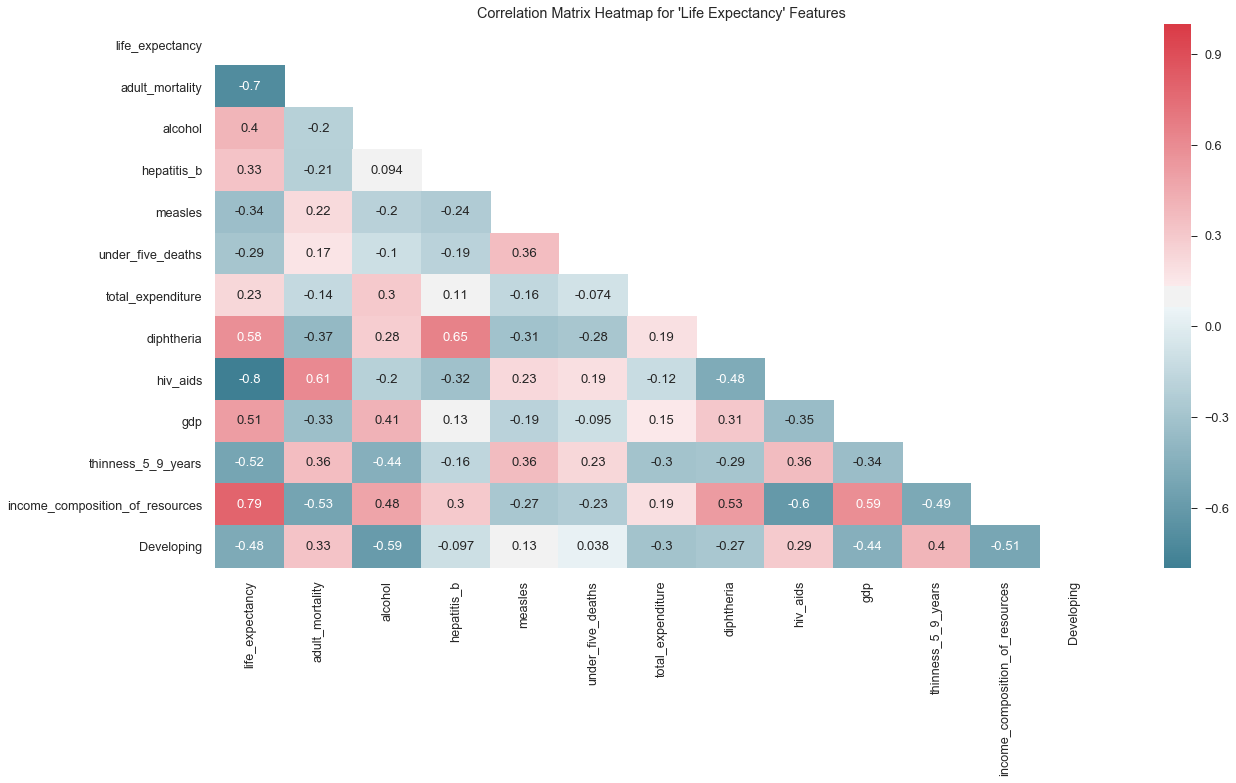

In [86]:
heatmap_plotter(df_fe_master)

***
### Principal Component Analysis: potential application for dimensionality reduction
***

In [87]:
# We should drop two additional variables: 'Developing' as it's basically a (categorical) binary indicator, and 'life_expectancy' the target variable
df_pca = df_fe_master.drop(columns = ['life_expectancy', 'Developing'])
df_pca.info() # Down to 11 variables

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 11 columns):
adult_mortality                    2928 non-null float64
alcohol                            2928 non-null float64
hepatitis_b                        2928 non-null float64
measles                            2928 non-null int64
under_five_deaths                  2928 non-null float64
total_expenditure                  2928 non-null float64
diphtheria                         2928 non-null float64
hiv_aids                           2928 non-null float64
gdp                                2928 non-null float64
thinness_5_9_years                 2928 non-null float64
income_composition_of_resources    2928 non-null float64
dtypes: float64(10), int64(1)
memory usage: 354.5 KB


In [88]:
# Standardize our matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
X = scale(df_pca)
sklearn_pca = PCA(n_components = 11)
Y_sklearn = sklearn_pca.fit_transform(X)
print('The percentage of total variance in the dataset explained by each component from Sklearn PCA:\n', sklearn_pca.explained_variance_ratio_)
print('Eigenvalues:\n', sklearn_pca.explained_variance_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.37087987 0.12111389 0.10526207 0.08807844 0.07420198 0.05880971
 0.05170225 0.04316266 0.03452936 0.02758671 0.02467306]
Eigenvalues:
 [4.08107239 1.332708   1.15827836 0.9691939  0.8165006  0.64712781
 0.56891907 0.47495142 0.37995274 0.30355745 0.27149637]


**What are we trying to achieve with PCA?**</br>


1. Calculate components that replace the factored variables, utilizing fewer components than original variables</br>

2. Simplify the data space</br>

3. Mitigate the curse of dimensionality</br>

For the current dataset, it looks like we would need the first 8 components to explain 90% of the information in the original data (11 variables). This isn't a tremendous simplification in data space. The first 3 components (i.e. eigenvalues > 1 thus adding more information than a single variable) would capture about 60% of the total variance. How do these look if we were to visualize the scree plot of eigenvalue versus Principal Component?</br>


Text(0, 0.5, 'Eigenvalue')

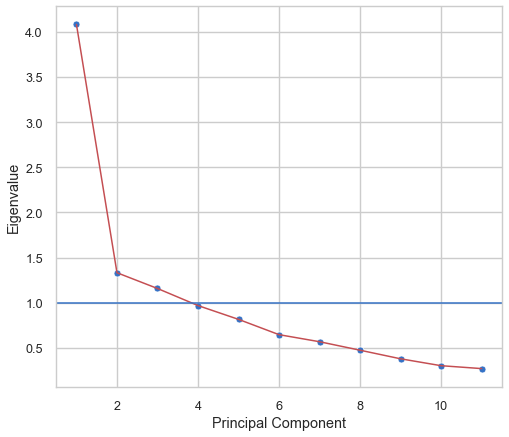

In [89]:
# Both scree plot visulaization AND >1 rule seem to match well. They both retain first 3 PCs 
t = sns.scatterplot(x = np.arange(1,12), y = sklearn_pca.explained_variance_)
t = sns.lineplot(x = np.arange(1,12), y = sklearn_pca.explained_variance_, color = 'r')
t.axhline(1)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

It seems like the scree plot's 'elbow' or most drastic change is at PC2-PC3, so for the most part agrees fairly well with the eigenvalue>1 guide for retaining a given number of components.

***
## Summary
***


### Data Cleaning


The imported master dataset consisted of 22 variables and 2938 observations. Noticeable nonsense values were detected in several variables including population, bmi, adult_mortality etc. A new population dataset was imported from the United States Census Bureau https://www.census.gov/data-tools/demo/idb/informationGateway.php, and once each country/year had been correctly populated, the original erroneous population variable was dropped. Several methods were also applied to treat other nonsense values. For bmi, for example, values outside a pre-determined realistic range (e.g. 10>bmi<40) were replaced with NaN values prior imputation steps.</br>

On a variable-by-variable basis (or pairs), the missing values ultimately were treated as much as possible using interpolation as this data set is a time series. Where necessary, missing values were imputed using the variable (column mean). Treating missing values on a variable-by-variable basis was performed in an effort to retain as much data as possible. Ultimately, these methods retained a total of 2928 observations from a starting 2938.</br>

Removal of outliers for continuous variables was performed using winsorization, with upper and lower percentile limits optimized on a column-by-column basis. Repeating Tukey's IQR revealed efficient removal of outliers.</br>

### Data Exploration

Univariate analysis initially was conducted for both continuous (winsorized) and categorical variables (e.g. counts for country, year, and status). Continuous variables for the most part showed non-normal distributions, with only a few winsorized variables visually tending towards normality, which included the target variable life_expectancy, schooling, and total_expenditure. However, statistical tests for normality (carried out using the Jarque-Bera test) revealed that none of the winsorized continuous variables to be drawn from a normal distribution. Univariate analysis of status revealed a significant disparity between the status levels, with 82.5 % of status being represented by 'Developing'.</br>

For multivariate analysis of continuous-continuous variables, correlation coefficients revealed several variables to have strong correlations with the target variable, life_expectancy. These included adult_mortality (positive relationship), hiv_aids (negative relationship), and income_composition_of_resources (positive relationship). Correlation analysis with visual representation using heatmaps clearly revealed strong correlations between other continuous variables, such as the relationship between diphtheria and polio as well as infant_deaths and under_five_deaths. 

Multivariate analysis also was performed for continuous-categorical variable relationships. Simple t-tests were performed to explore the influence of status on continuous variable data, and most variables were significantly different as a function of status (except for infant_deaths). The target variable, life_expectancy, for instance was on average 12 years higher for developed countries (t-statistic = 48; p-value << 0.001). Life expectancy also was seen to increase across the 15 years under investigation. However, no significant differences existed on a year-to-year basis as explored using t-tests. While the status categorical variable was deemed critical to include in later feature engineering steps, the year variable was not.

### Feature Engineering

The categorical variable 'status' initially was transformed to numeric using one-hot encoding. In addition, 'year' and 'country' were dropped from further analysis. As many models assume that features are correlated with outcome but uncorrelated with each other,  highly correlated variables were considered (r threshold of +/-0.7) and the variable with the lower correlation to the target variable was dropped. This resulted in a set of 12 features as shown in the info() output and heatmap below.

In [90]:
df_fe_master.loc[:,df_fe_master.columns[1:]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 12 columns):
adult_mortality                    2928 non-null float64
alcohol                            2928 non-null float64
hepatitis_b                        2928 non-null float64
measles                            2928 non-null int64
under_five_deaths                  2928 non-null float64
total_expenditure                  2928 non-null float64
diphtheria                         2928 non-null float64
hiv_aids                           2928 non-null float64
gdp                                2928 non-null float64
thinness_5_9_years                 2928 non-null float64
income_composition_of_resources    2928 non-null float64
Developing                         2928 non-null uint8
dtypes: float64(10), int64(1), uint8(1)
memory usage: 357.4 KB


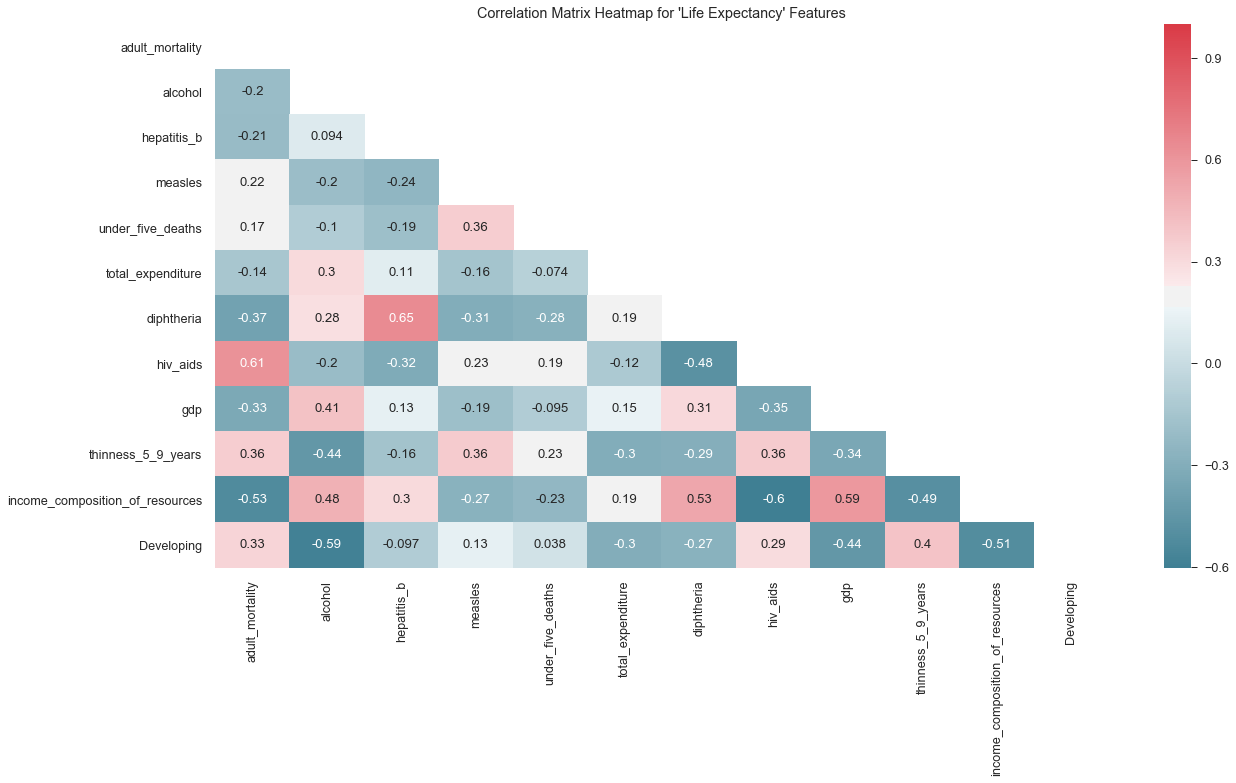

In [91]:
heatmap_plotter(df_fe_master.loc[:,df_fe_master.columns[1:]])

Could dimensionality reduction be enhanced using PCA? To explore this option, we first removed the life_expectancy and the binary (categorical) Developing indicator prior to PCA. Considering the remaining 11 features and running PCA, only the first three principal components had eigenvalues of >1 and accounted for only 60% of the total variance of the 11-variable dataset.</br>

In conclusion, it is likely better to initiate the modeling using the 12 features identified in the heatmap above prior to PCA applications. Rescaling of the variables is also recommended as most machine learning models expect a fixed limited range and/or exhibit regular statistical distributions/patterns.